In [2]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

In [3]:
data_dir_full=db.query('owner=="roman"')['data_dir_full'][2]
data_dir_full
db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)

data_dir_full  \
animal_name                                                        
e13_26m1    0  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e15_13f1    0  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            3  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
...                                                          ...   
e16_2m1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m...   
e16_1f1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
e14_2m3     0  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   

                     sess_name animal_name.1        date  \
animal_name                                                
e13_26m1    0  e13_26m1_210913      e13_26m1  2021-09-13   
e15_13f1    0  e15_13f1_220117      e15_13f1  2022-01-17   
            1  e15_13f1_220118      e15_13f1  2022-01-18   
            2  e15_13f1_220119      e15_13f1  2022-01-19   
            3  e15_13f1_220120      e15_13f1  2022-01-20   
...                        ...           ...         ...   
e16_2m1     0   e16_2m1_201116       e16_2m1  2020-11-16   
e16_1f1     0   e16_1f1_200823       e16_1f1  2020-08-23   
            1   e16_1f1_200824       e16_1f1  2020-08-24   
e14_2m3     0   e14_2m3_201017       e14_2m3  2020-10-17   
            1   e14_2m3_201019       e14_2m3  2020-10-19   

                                    behavior  performance  ntrials  \
animal_name                                                          
e13_26m1    0                    alternation     0.956522       69   
e15_13f1    0                    alternation     0.617647       34   
            1   ['alternation' 'linearMaze']     0.740741       27   
            2  ['alternation' 'alternation']     0.721311       61   
            3   ['alternation' 'linearMaze']     0.800000       45   
...                                      ...          ...      ...   
e16_2m1     0                    alternation     0.636364       11   
e16_1f1     0                    alternation     0.631579       19   
            1                    alternation     0.571429       21   
e14_2m3     0                    alternation     0.615385       26   
            1                    alternation     0.863636       22   

               ngoodtrials  n_neurons  n_pyr_putative  owner   data_root  
animal_name                                                               
e13_26m1    0           69        482             422  roman  roman_data  
e15_13f1    0           34        376             333  roman  roman_data  
            1           27        363             318  roman  roman_data  
            2           61        343             288  roman  roman_data  
            3           45        303             248  roman  roman_data  
...                    ...        ...             ...    ...         ...  
e16_2m1     0           11         50              37  roman  roman_data  
e16_1f1     0           19         47              32  roman  roman_data  
            1           21         40              27  roman  roman_data  
e14_2m3     0           26         34              26  roman  roman_data  
            1           22         36              22  roman  roman_data  

[67 rows x 12 columns]

In [96]:
db.query('animal_name=="e15_13f1"')

data_dir_full  \
animal_name                                                        
e15_13f1    0  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            3  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   

                     sess_name animal_name.1        date  \
animal_name                                                
e15_13f1    0  e15_13f1_220117      e15_13f1  2022-01-17   
            1  e15_13f1_220118      e15_13f1  2022-01-18   
            2  e15_13f1_220119      e15_13f1  2022-01-19   
            3  e15_13f1_220120      e15_13f1  2022-01-20   

                                    behavior  performance  ntrials  \
animal_name                                                          
e15_13f1    0                    alternation     0.617647       34   
            1   ['alternation' 'linearMaze']     0.740741       27   
            2  ['alternation' 'alternation']     0.721311       61   
            3   ['alternation' 'linearMaze']     0.800000       45   

               ngoodtrials  n_neurons  n_pyr_putative  owner   data_root  
animal_name                                                               
e15_13f1    0           34        376             333  roman  roman_data  
            1           27        363             318  roman  roman_data  
            2           61        343             288  roman  roman_data  
            3           45        303             248  roman  roman_data

In [126]:
data_dir_full=db.query('animal_name=="e15_13f1"')['data_dir_full'].iloc[3]

In [75]:
reload(dpp)
reload(dpn)

<module 'data_prep_new' from '/mnt/home/szheng/projects/util_code/data_prep_new.py'>

In [127]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
# data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][2] #0

# load data
mat_to_return=prep.load_stuff(data_dir_full)
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']


prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']

# import nmf_one_session as nos
# from itertools import product
# reload(nos)
# condition_df = {'do_normalize':[True,False],'speed_thresh':[0,1,5],'israte':[True,False]}
# condition_df = pd.DataFrame(list(product(*condition_df.values())),columns=list(condition_df.keys()))
# n_compo = 4
# nmf_res_d = {}

# for _,combo in condition_df.iterrows():
#     do_normalize,speed_thresh,israte = combo['do_normalize'],combo['speed_thresh'],combo['israte']
#     res_to_save_name = f'nmf_{n_compo}_normalize_{do_normalize}_speedthresh_{int(speed_thresh)}_rate_{israte}'
#     nmf_res_d[tuple(combo.values)]=nos.nmf_one_session(data_dir_full,kwargs_={'n_compo':n_compo,'doplots':False,'n_clust':6,'do_normalize':do_normalize,'force_reload':False,'dosave':False,'speed_thresh':speed_thresh,'res_to_save_name':res_to_save_name,'israte':israte})




In [128]:
# get place fields!!!!
import place_field_analysis as pf
reload(pf)

cell_cols = cell_cols_d['pyr']
spk_beh_df = dpp.add_lin_binned(spk_beh_df,nbins=100)
_,spk_beh_df=dpp.group_into_trialtype(spk_beh_df)
fr_map_d,count_d,occu_d = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols,speed_thresh=1.,nbins=100,smth_in_bin=2.5)


# get fields
fr_map_peaks_d = {}
field_res_d = {}
min_rate=0.6
for key in fr_map_d.keys():

    fr_map = fr_map_d[key]
    count = count_d[key]
    occu = occu_d[key]
    field_res_d[key] =pf.get_field_peaks_one_trialtype(fr_map,count,occu,min_rate=min_rate)
    


In [129]:
# get field params!!!!!
reload(pa)
gpb = spk_beh_df.groupby('trial_type')
field_params_all = {}
fr_map_trial_all = {}
X_all = {}
X_all_norm = {}
for key,val in gpb:
    fr_map_trial,count_trial,occu_trial = pa.get_fr_map_trial_onegroup(val,cell_cols_d['pyr'],gauss_width=2.5,order=['smooth','divide'],n_lin_bins=100,speed_thresh=1)
    fr_map_trial_df = pf.fr_map_trial_to_df(fr_map_trial,cell_cols_d['pyr'])
    
    field_params_trial=pf.get_field_params_trial(fr_map_trial_df,field_res_d[key]['all_fields'])
    fr_map_trial_all[key] = fr_map_trial_df
    field_params_all[key]=field_params_trial
    X_all[key] = field_params_trial.loc['fr']
    
    X_all_norm[key] = X_all[key] / X_all[key].max(axis=1).values[:,None]
    

cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe


In [130]:
import ruptures as rpt


from pandarallel import pandarallel

In [10]:
# pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [131]:
%%time

pen_l = [0.1,0.3,0.6]
X_norm_pwc_d_allpen = {}
min_size = 1
for pen in pen_l:
    X_norm_pwc_d = {}
    for k,X in X_all.items():
        %time X_norm_pwc,cpts = cpa.predict_from_cpts_wrapper_allrows(X,pen,min_size=min_size)
        X_norm_pwc_d[k] = X_norm_pwc
    X_norm_pwc_d_allpen[pen] = X_norm_pwc_d
X_to_be_analyzed = {'raw':X_all_norm}
X_to_be_analyzed.update(X_norm_pwc_d_allpen)

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 112 ms, sys: 2.68 s, total: 2.8 s
Wall time: 3.07 s
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 137 ms, sys: 2.63 s, total: 2.76 s
Wall time: 2.99 s
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 52.6 ms, sys: 1.1 s, total: 1.16 s
Wall time: 1.33 s
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 122 ms, sys: 2.6 s, total: 2.73 s
Wall time: 2.96 s
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: 

/mnt/home/szheng/projects/nmf_analysis/change_point_plot.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axs = plt.subplots(len(keys),2,figsize=(6*2,3*len(keys)),sharey=False)


CPU times: user 4min 4s, sys: 8.28 s, total: 4min 12s
Wall time: 3min 55s


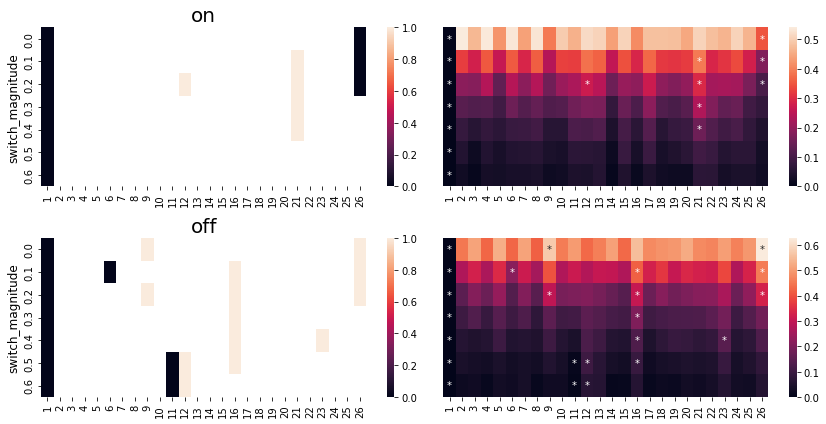

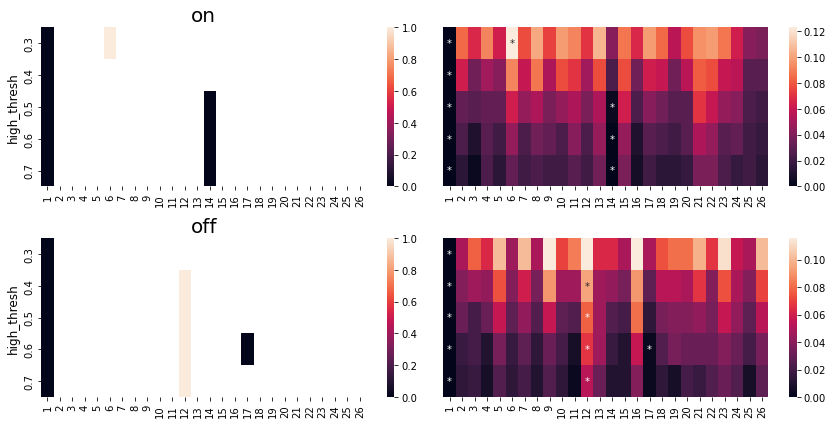

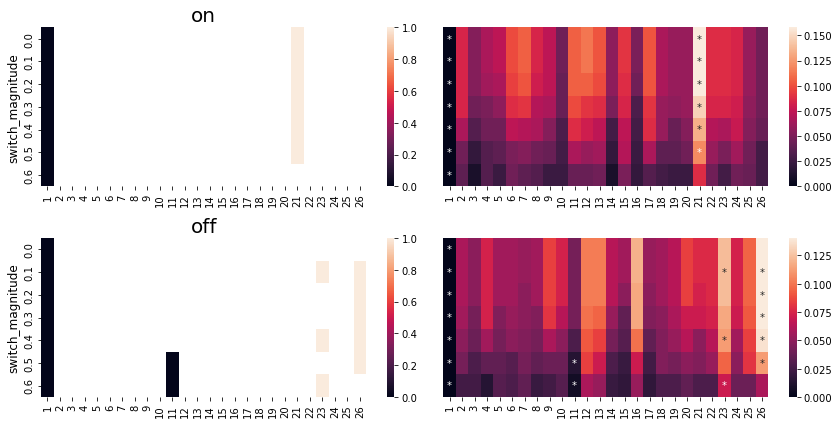

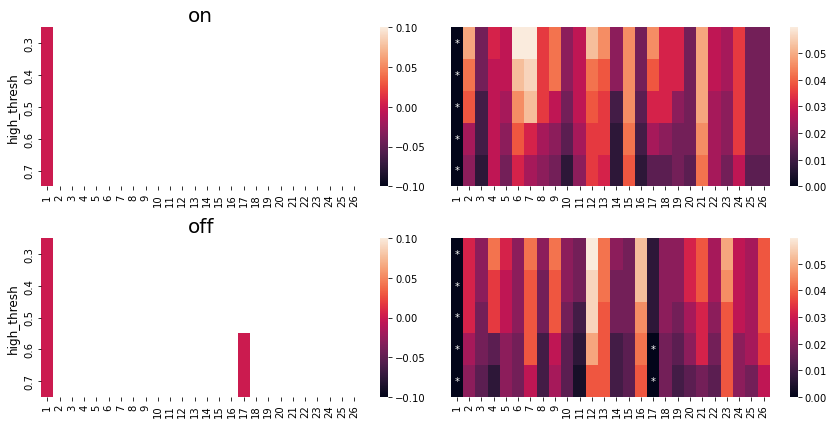

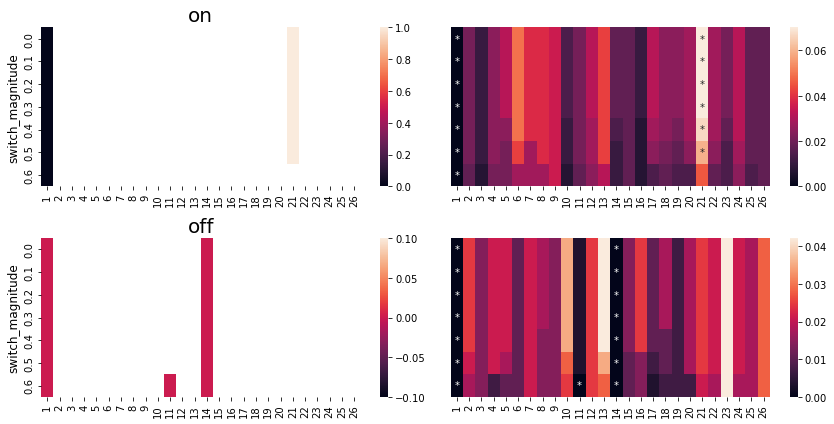

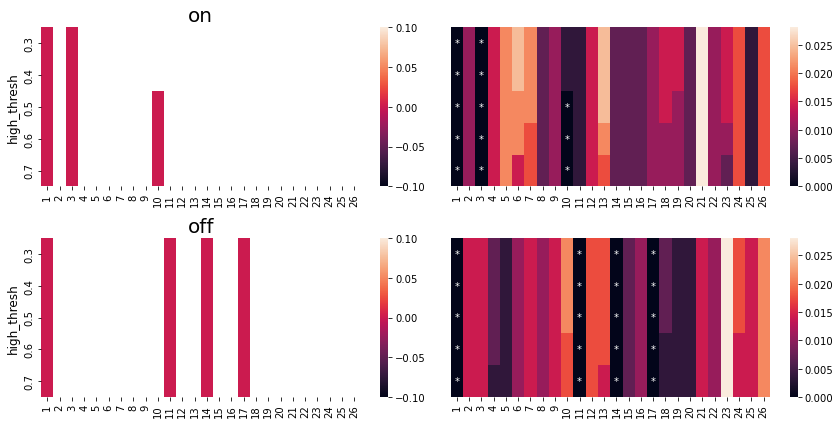

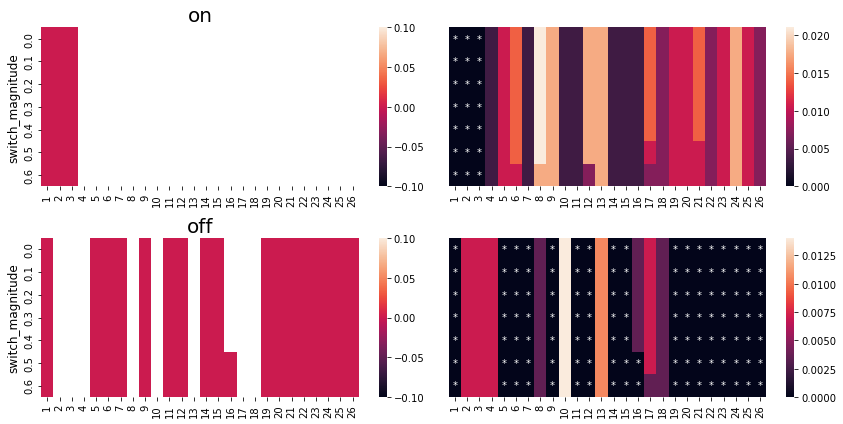

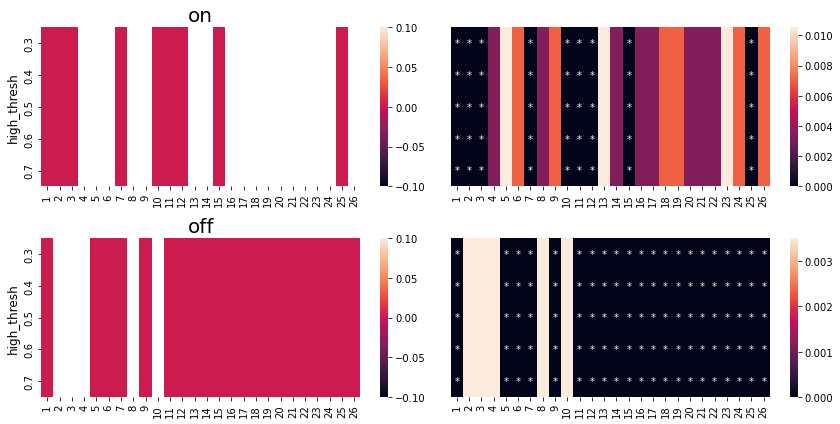

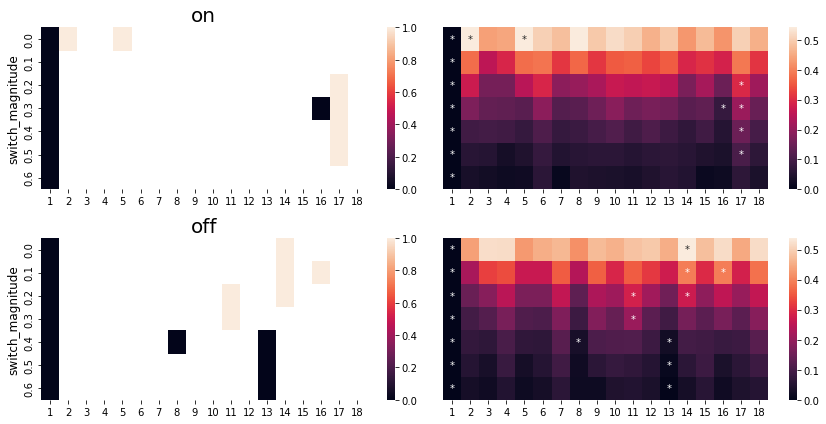

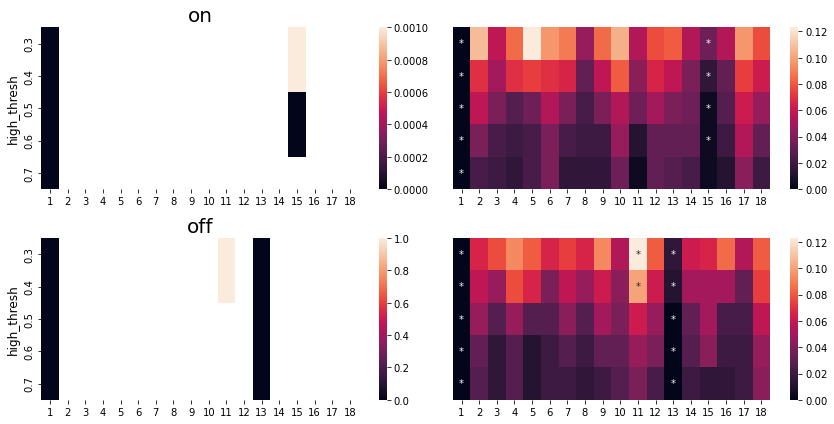

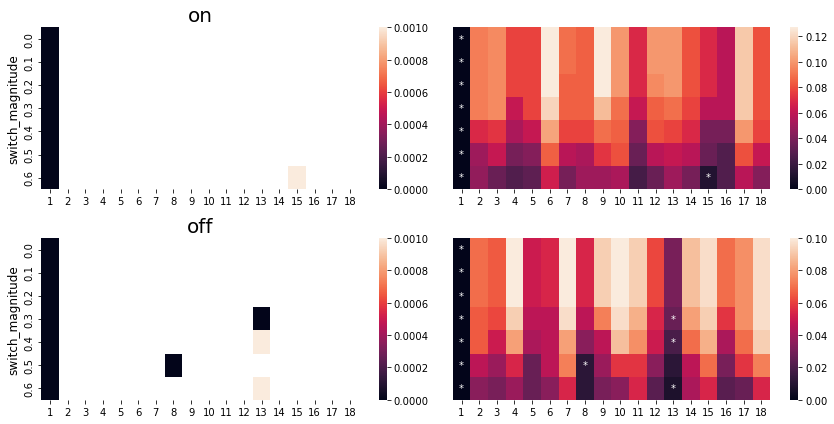

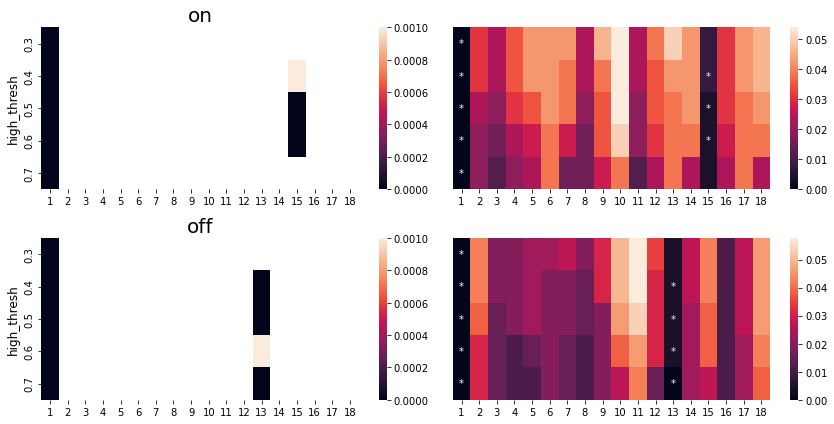

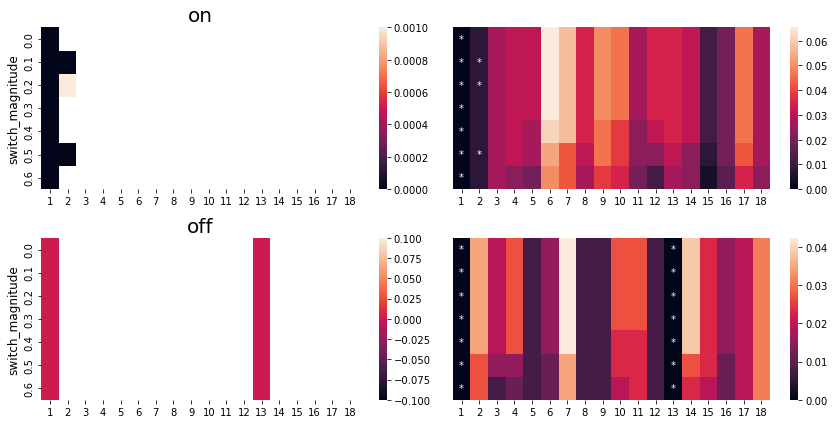

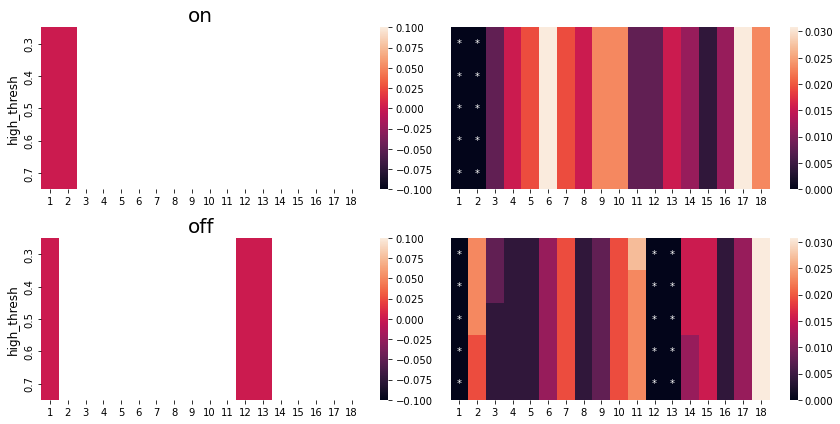

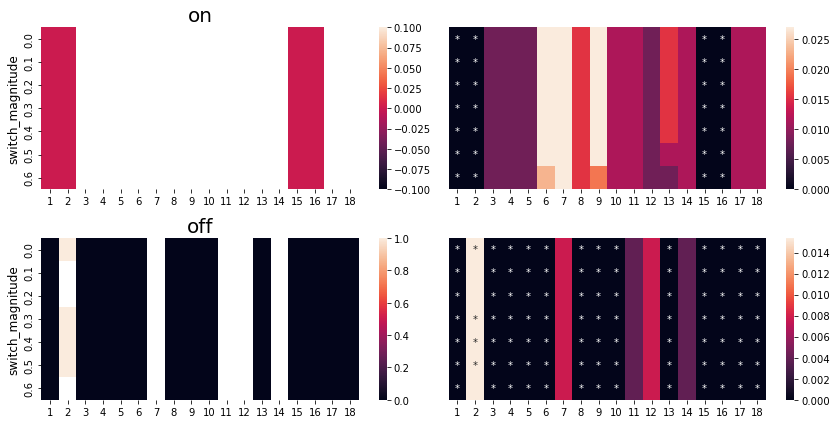

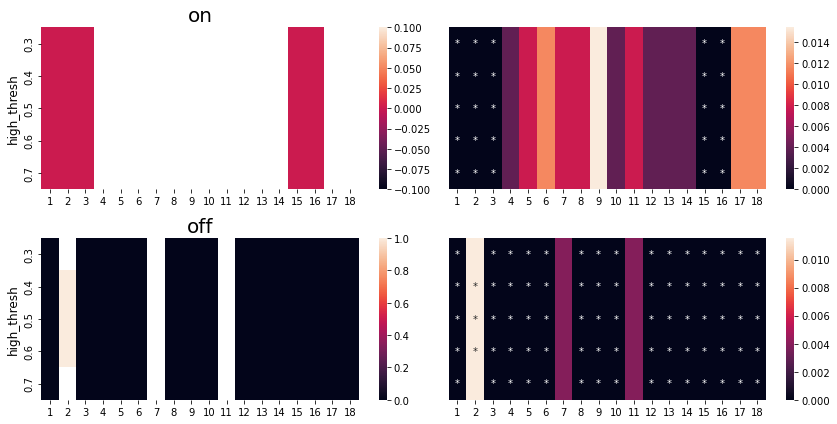

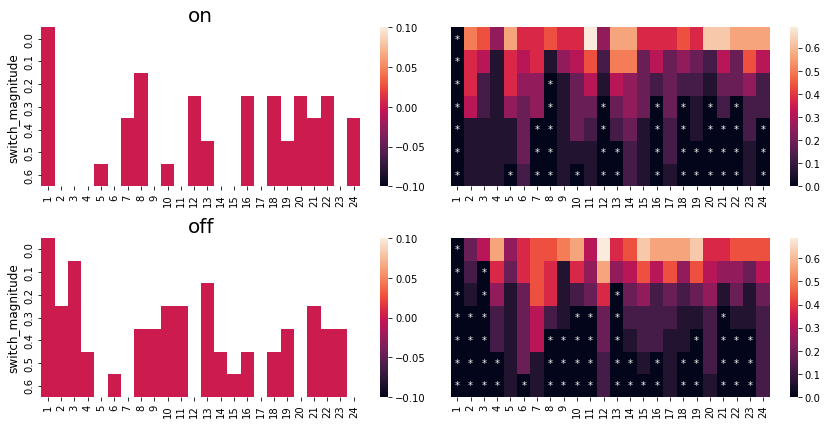

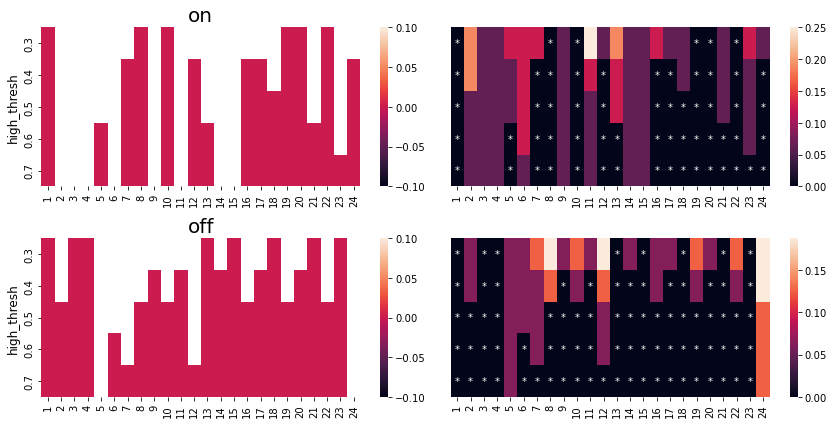

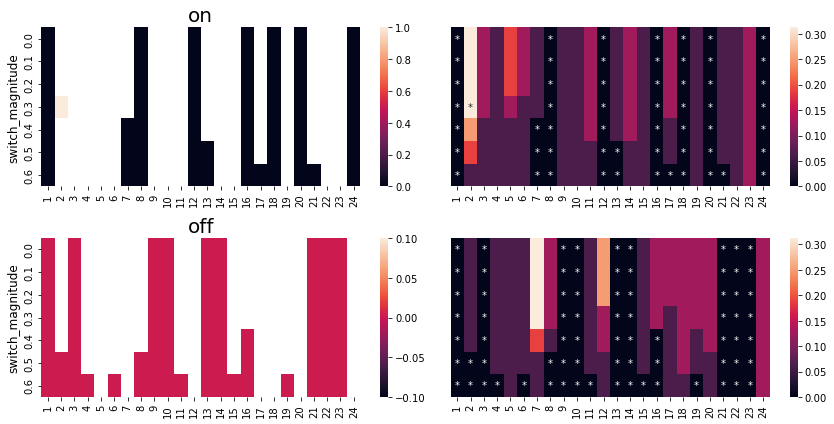

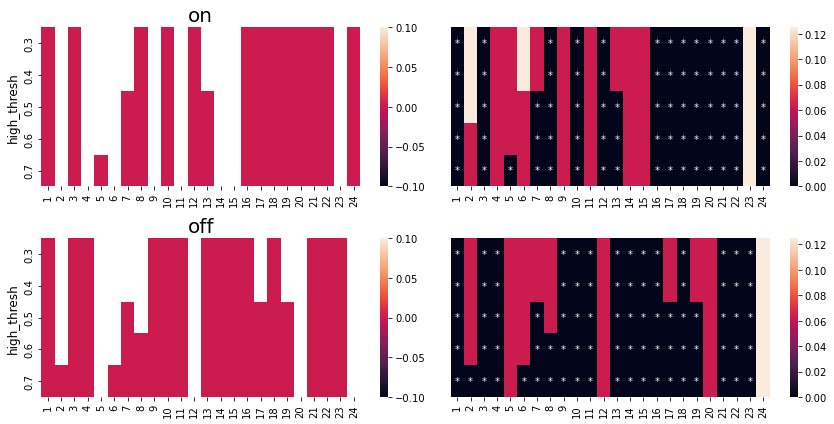

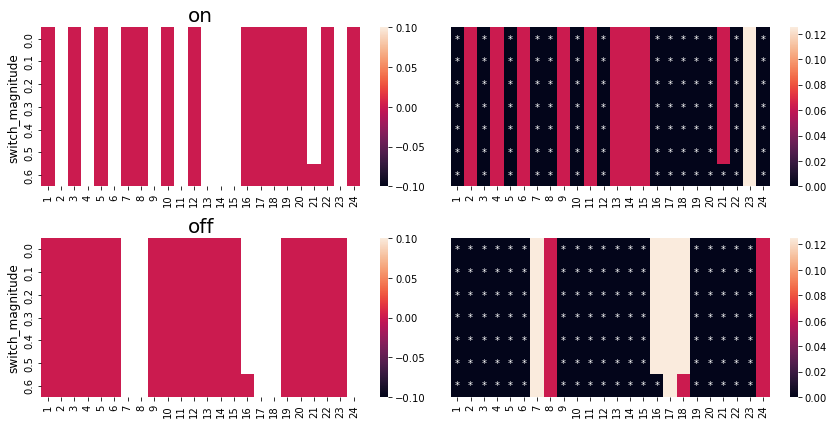

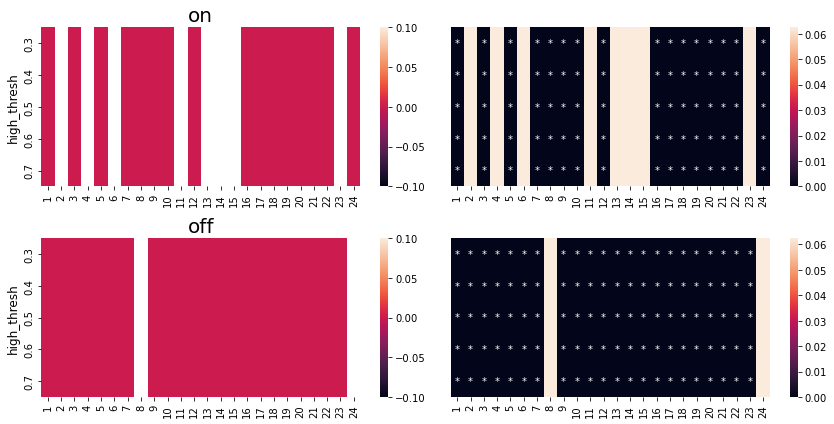

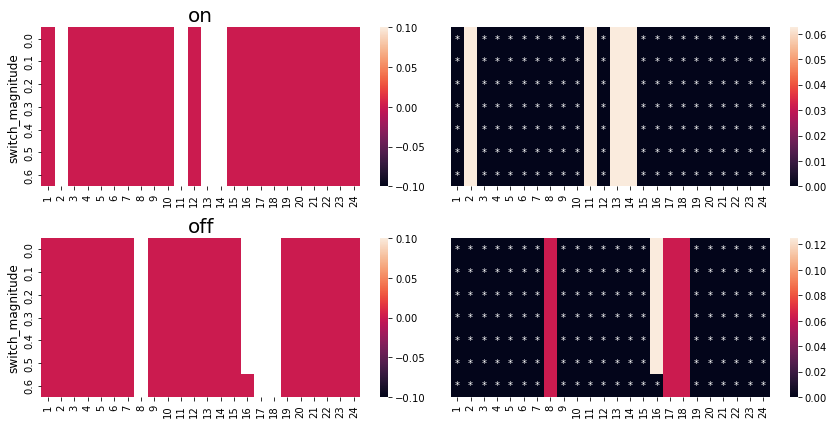

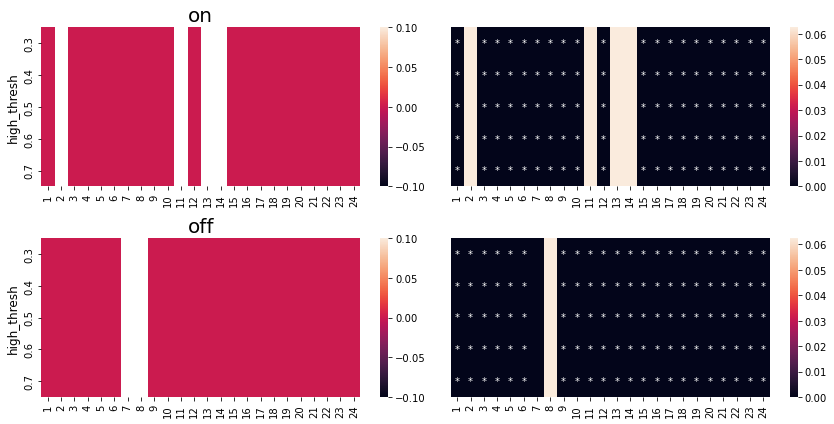

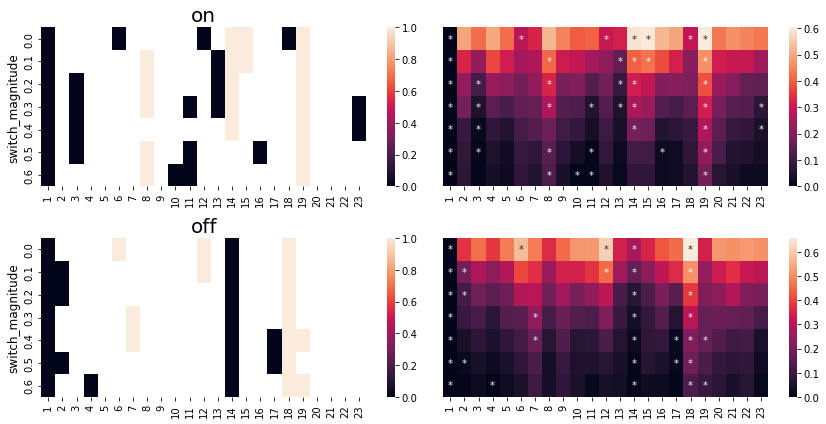

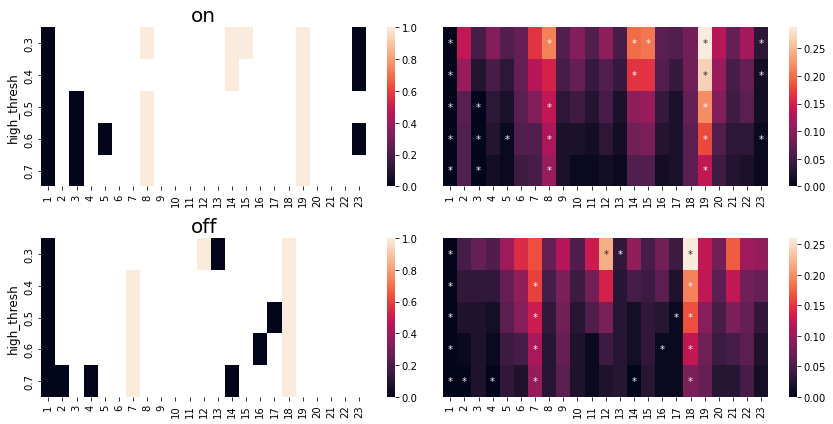

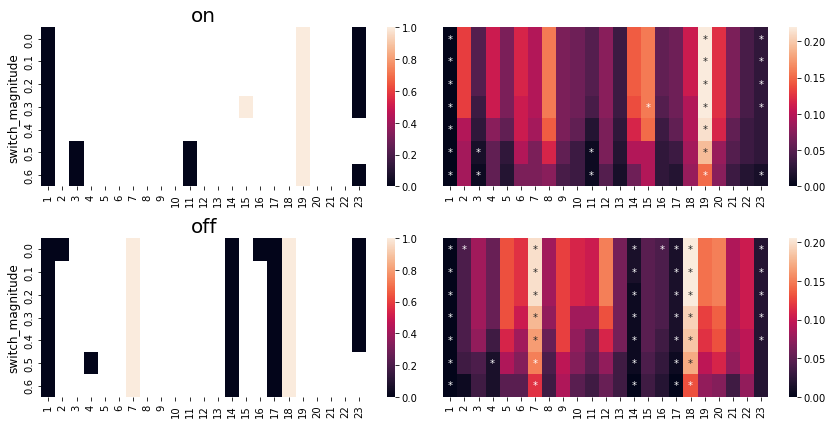

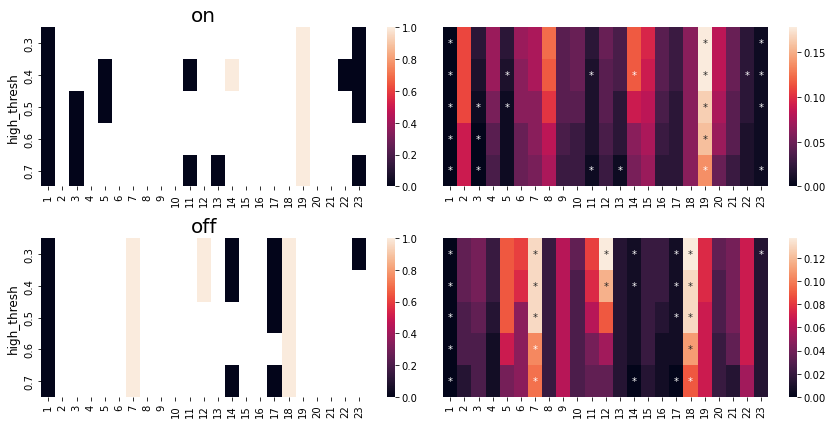

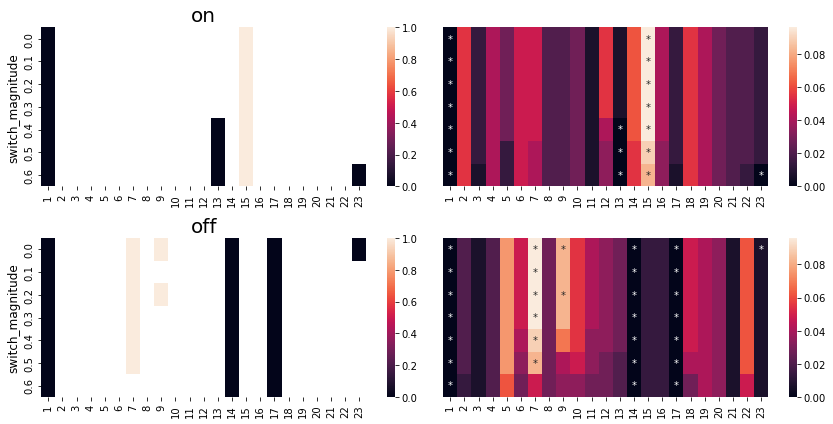

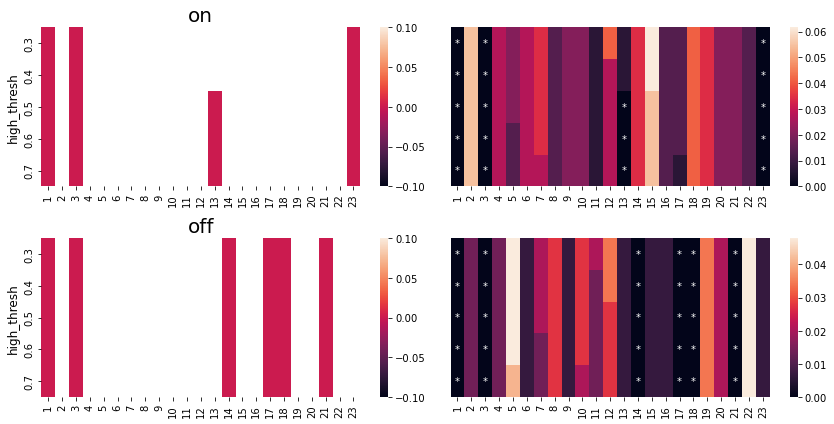

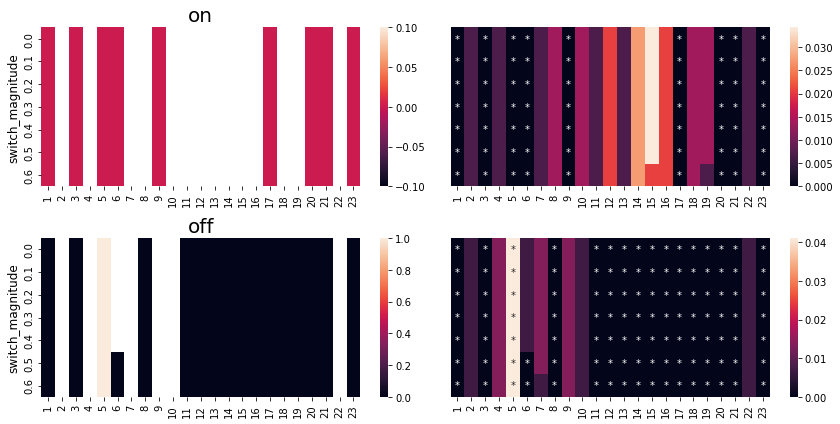

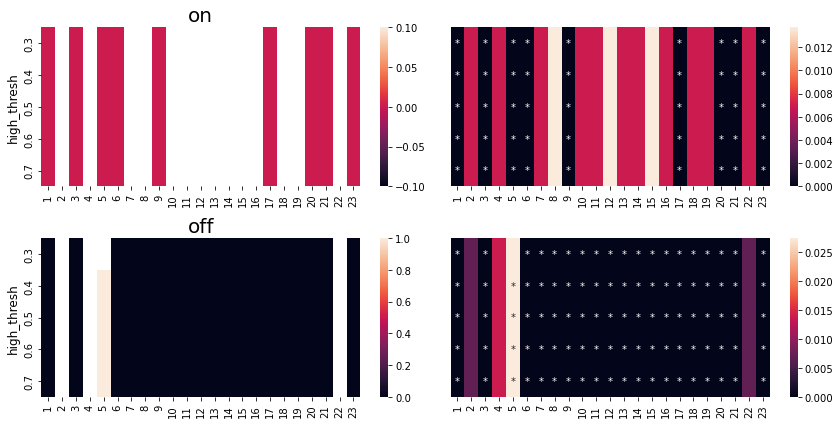

In [132]:
%%time
plt.ioff()
tosweep_key_l = ['switch_magnitude','high_thresh']
tosweep_val_l = [np.arange(0,0.7,0.1).round(1),np.arange(0.3,0.8,0.1).round(1)]
kwargs_l = [dict(low_thresh=1,high_thresh=0),
    dict(low_thresh=0.2,switch_magnitude = 0),
]
cdf_alltrialtype,sig_alltrialtype,sr_alltrialtype,changes_df_alltrialtype,fig_alltrialtype = cpa.sweep_test_switch_ratio_multisweep_alltrialtype_multipreprocess(X_to_be_analyzed,min_size,tosweep_key_l,tosweep_val_l,kwargs_l,detect_func=cpa.detect_switch_pwc,alpha=0.05,do_bonf=True,doplots=True,nrepeats=1000)    

res_to_save_data = dict(
    X = X_to_be_analyzed,
    cdf=cdf_alltrialtype,
    sig=sig_alltrialtype,
    sr=sr_alltrialtype,
    changes_df=changes_df_alltrialtype,
    fig=fig_alltrialtype
)

In [133]:
res_to_save_dir = os.path.join(data_dir_full,'py_data','switch_analysis')
if not os.path.exists(res_to_save_dir):
    os.makedirs(res_to_save_dir)
    print(f'{res_to_save_dir} made!',flush=True)

res_to_save_name = f'switch_res'
res_to_save_fn  = os.path.join(res_to_save_dir,res_to_save_name+'.p')

pickle.dump(res_to_save_data,open(res_to_save_fn,'wb'))
print(f'{res_to_save_fn} saved!', flush=True)

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/switch_analysis/switch_res.p saved!


In [123]:
tosweep_key

'high_thresh'

/tmp/ipykernel_1096858/3186532728.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes=res_to_save_data['changes_df'].loc[(*trialtype,pen,tosweep_key,tosweep_val),:]


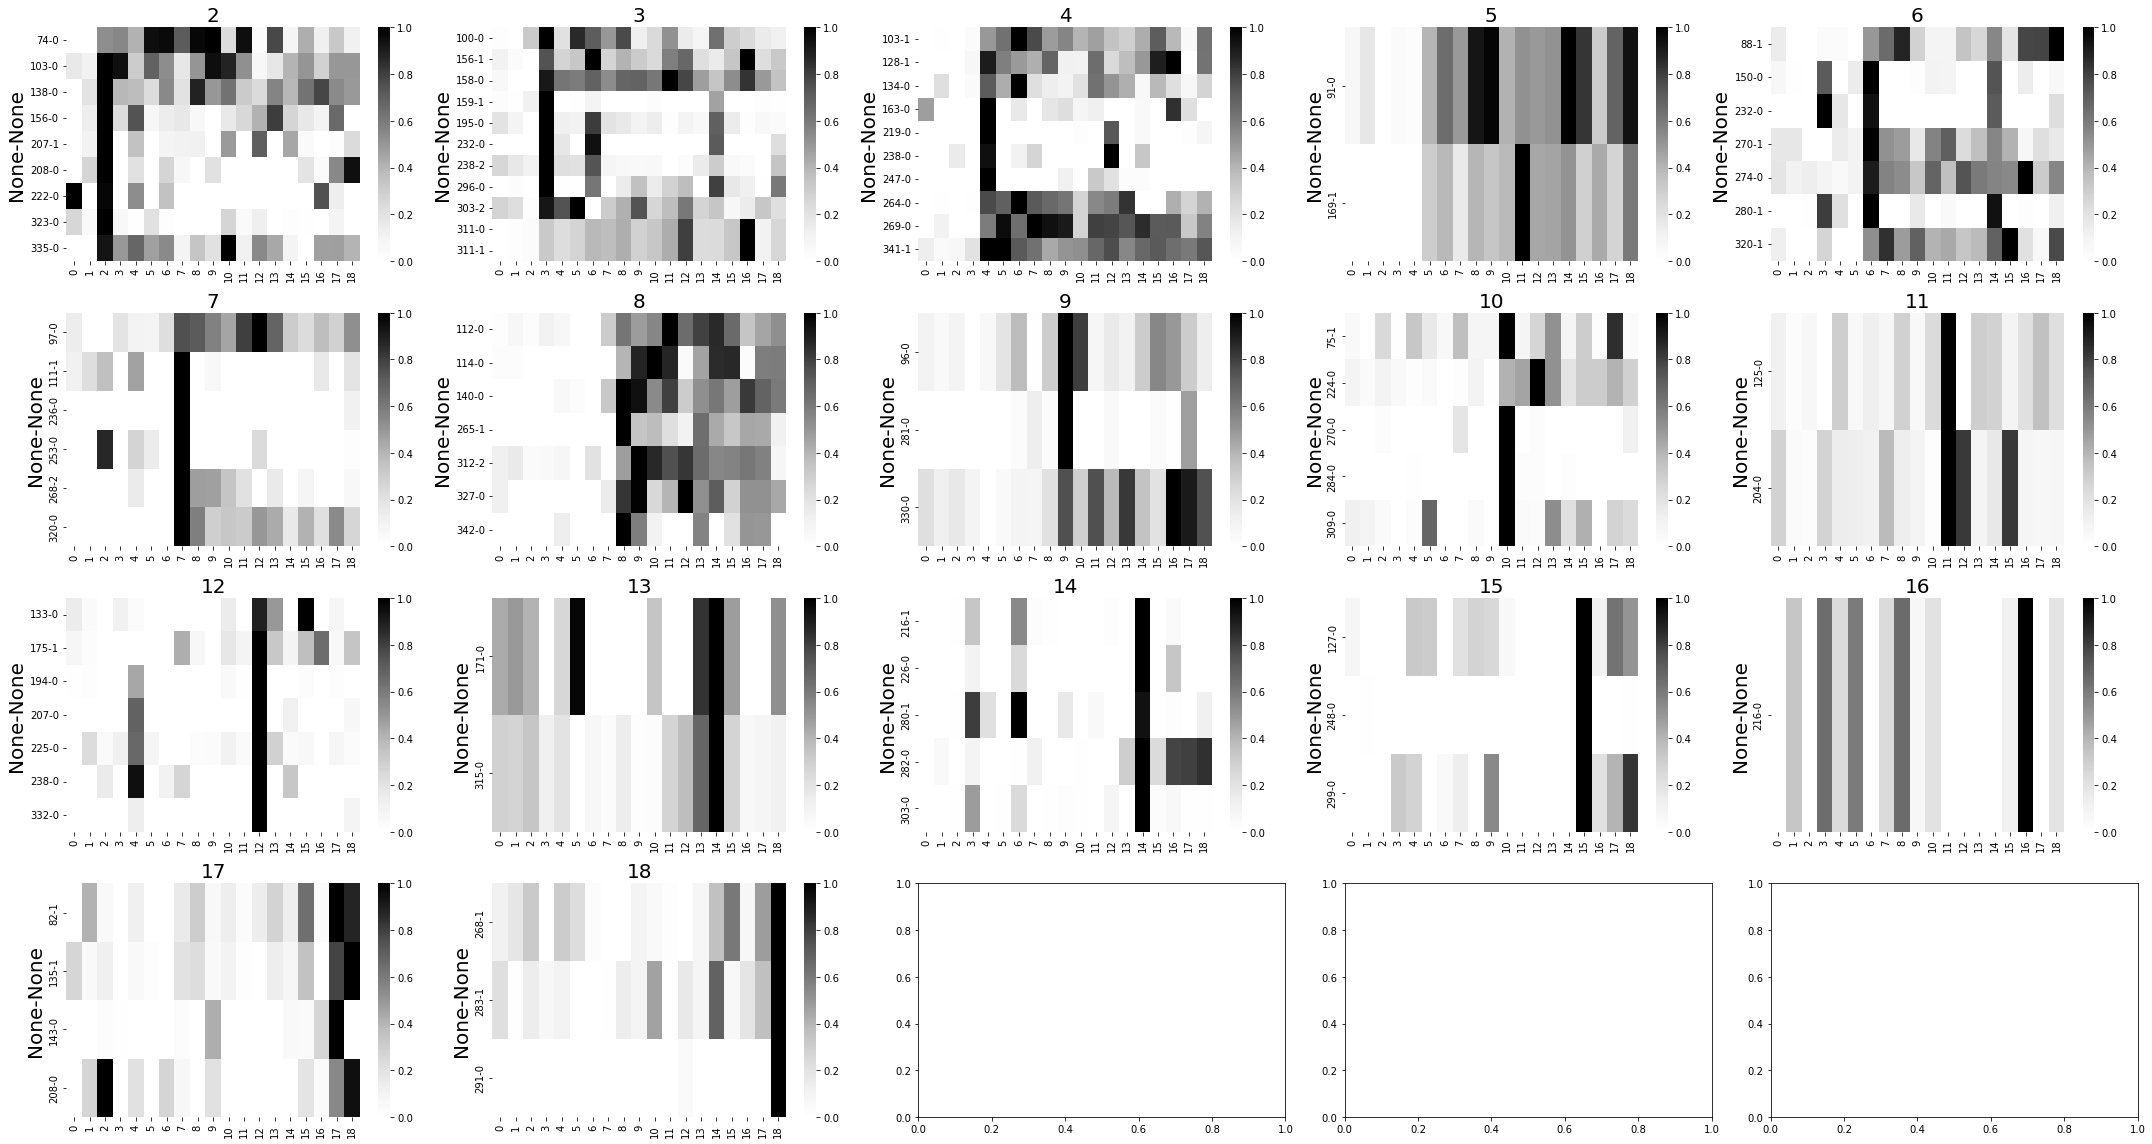

In [125]:
trialtype = (0,0)
pen = 0.3
tosweep_key = 'high_thresh'
tosweep_val = 0.5
changes=res_to_save_data['changes_df'].loc[(*trialtype,pen,tosweep_key,tosweep_val),:]
inds_d = cpa.get_inds_switch_sametrial_sorted(changes)
fig,axs=cpp.plot_fields_switching_each_trial(X_to_be_analyzed['raw'][trialtype],inds_d.loc[1])

In [114]:
%%time
# plots
from matplotlib.backends.backend_pdf import PdfPages
fig_to_save_dir = os.path.join(data_dir_full,'py_figures','switch_analysis')
if not os.path.exists(fig_to_save_dir):
    os.makedirs(fig_to_save_dir)
    print(f'{fig_to_save_dir} made!',flush=True)
fig_to_save_fn = os.path.join(fig_to_save_dir,f'{res_to_save_name}.pdf')

target_pen = ['raw',0.3]
target_tosweep_keyval ={'switch_magnitude':0.3,'high_thresh':0.5,'low_thresh':1.} 

fig_alltrialtype = res_to_save_data['fig']
X_to_be_analyzed = res_to_save_data['X']
with PdfPages(fig_to_save_fn) as pdf:
    for trialtype,val in fig_alltrialtype.items():
        for pen, valval in val.items():
            for tosweep_key,valvalval in valval.items():
                title = f'trialtype={trialtype},preprocess={pen}\n tosweep={tosweep_key}'
                # import pdb
                # pdb.set_trace()
                valvalval.suptitle(title,fontsize=12)
                plt.tight_layout()
                pdf.savefig(figure=valvalval,bbox_inches='tight')
                plt.close(fig=valvalval)
                if (pen in target_pen):
                    tosweep_val = target_tosweep_keyval[tosweep_key]
                    changes=res_to_save_data['changes_df'].loc[(*trialtype,pen,tosweep_key,tosweep_val),:]
                    inds_d = cpa.get_inds_switch_sametrial_sorted(changes)
                    fig,axs=cpp.plot_fields_switching_each_trial(X_to_be_analyzed['raw'][trialtype],inds_d.loc[1])
                    fig.suptitle(title,fontsize=12)
                    pdf.savefig(figure=fig,bbox_inches='tight')
                    plt.close(fig=fig)

<timed exec>:27: PerformanceWarning: indexing past lexsort depth may impact performance.
<timed exec>:27: PerformanceWarning: indexing past lexsort depth may impact performance.
<timed exec>:27: PerformanceWarning: indexing past lexsort depth may impact performance.
<timed exec>:27: PerformanceWarning: indexing past lexsort depth may impact performance.
<timed exec>:27: PerformanceWarning: indexing past lexsort depth may impact performance.
<timed exec>:27: PerformanceWarning: indexing past lexsort depth may impact performance.
<timed exec>:27: PerformanceWarning: indexing past lexsort depth may impact performance.
<timed exec>:27: PerformanceWarning: indexing past lexsort depth may impact performance.
<timed exec>:27: PerformanceWarning: indexing past lexsort depth may impact performance.
<timed exec>:27: PerformanceWarning: indexing past lexsort depth may impact performance.
<timed exec>:27: PerformanceWarning: indexing past lexsort depth may impact performance.
<timed exec>:27: Perf

CPU times: user 5min 10s, sys: 5.05 s, total: 5min 15s
Wall time: 5min 7s


<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

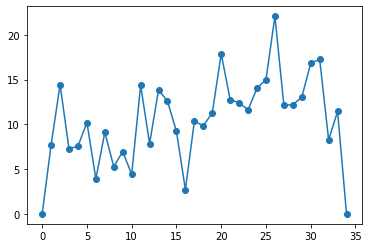

In [273]:
X_all[key].iloc[7].plot(marker='o')

<AxesSubplot:>

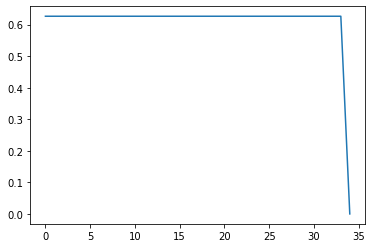

In [279]:
X_norm_pwc_d_allpen[0.2][key].iloc[6].plot()

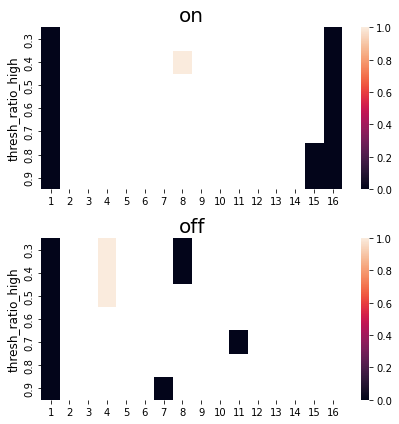

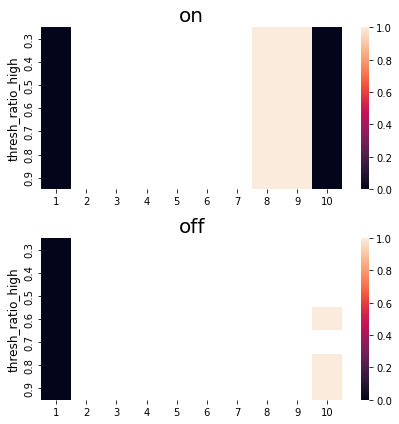

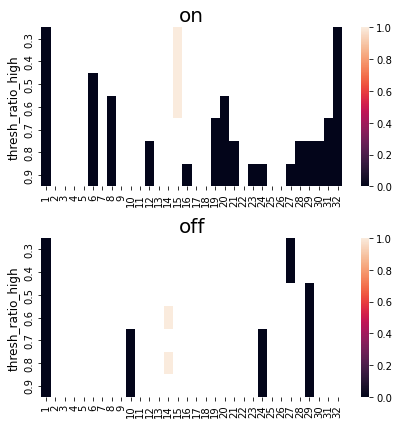

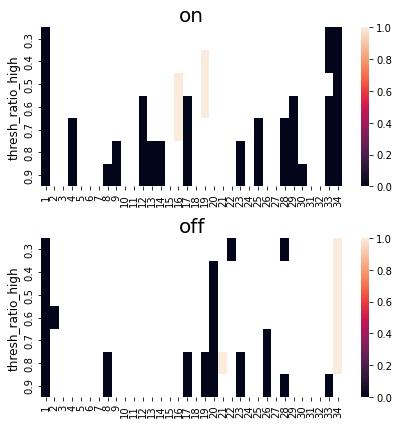

In [280]:
# sweeping magnitude; original data no cpd
reload(cpa)

pen = 0.5
min_size = 1
for key,X in X_all.items():

    tosweep_key = 'thresh_ratio_high'
    tosweep_val = [0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    kwargs = dict(thresh_ratio_low=0.2,thresh_ratio_high=0.4,sustain_on=2)
    doplots = True
    cdf_d_d,sig_d_d,sr_data_d,changes_df_d,fig,axs = cpa.sweep_test_switch_ratio(X.iloc[:,min_size:],tosweep_key,tosweep_val,detect_func=cpa.detect_switch_by_change,alpha=0.05,do_bonf=True,doplots=doplots,nrepeats=400,**kwargs)


In [368]:
np.arange(0,1,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

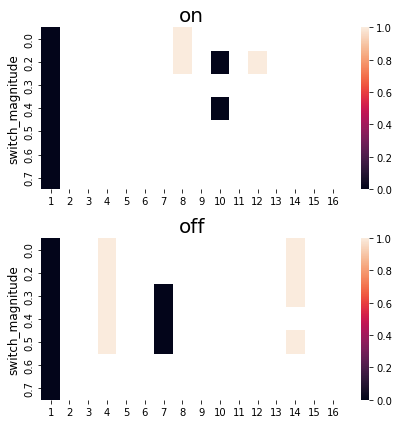

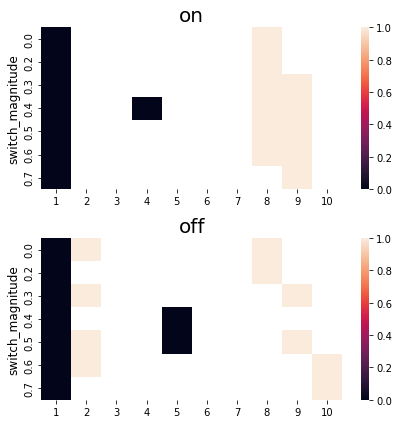

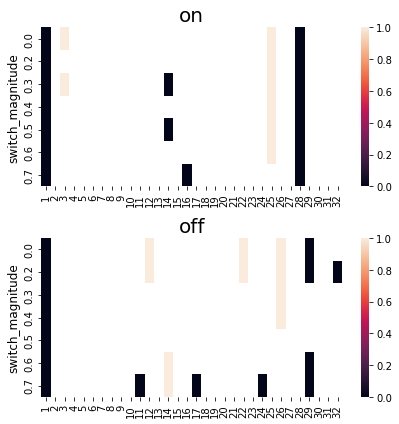

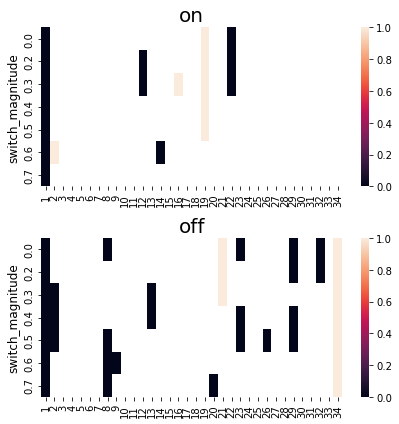

In [282]:
# sweeping magnitude; which might be equivalent to changing the pen in CPD
reload(cpa)

pen = 0.1
min_size = 1
changes_df_d_all = {}
for key,X_norm_pwc in X_norm_pwc_d_allpen[pen].items():

    tosweep_key = 'switch_magnitude'
    tosweep_val = [0,0.2,0.3,0.4,0.5,0.6,0.7]
    kwargs = dict(low_thresh=1,high_thresh=0)
    doplots = True
    if min_size > 1:
        cdf_d_d,sig_d_d,sr_data_d,changes_df_d,fig,axs = cpa.sweep_test_switch_ratio(X_norm_pwc.iloc[:,min_size:(-(min_size-1))],tosweep_key,tosweep_val,detect_func=cpa.detect_switch_pwc,alpha=0.05,do_bonf=True,doplots=doplots,nrepeats=400,**kwargs)
    else:
        cdf_d_d,sig_d_d,sr_data_d,changes_df_d,fig,axs = cpa.sweep_test_switch_ratio(X_norm_pwc.iloc[:,min_size:],tosweep_key,tosweep_val,detect_func=cpa.detect_switch_pwc,alpha=0.05,do_bonf=True,doplots=doplots,nrepeats=400,**kwargs)
    changes_df_d_all[key] = changes_df_d

In [378]:
pd.concat(changes_df_alltrialtype,axis=0)

2   3   4   5   6   7   8   9    10   11  ...   24   25   26  \
0 0.0 0.0 1   0   0   0   0   0   0   0   0   0  0.0  0.0  ...  NaN  NaN  NaN   
          39  0   0   0   0   0   0   0   0   0  0.0 -1.0  ...  NaN  NaN  NaN   
          40  0   0   0   0   1  -1   0   0   0  0.0  0.0  ...  NaN  NaN  NaN   
              1   0   0   0   0   0   0   0   0  0.0  0.0  ...  NaN  NaN  NaN   
          42  0   0   0   0   0   0   0   0   0  0.0  0.0  ...  NaN  NaN  NaN   
...              ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...   
1 1.0 0.7 352 0   0   0   1   0   0   0   0   0  0.0  0.0  ...  0.0  0.0  0.0   
          353 0   0   0   1   0   0   0   0   0  0.0  0.0  ...  0.0  0.0  0.0   
          354 0   0   0   0   0   0   0   0   0  0.0  0.0  ...  0.0  0.0  0.0   
          359 0   0   0   0   0   0   0   0   0  0.0  0.0  ...  0.0  0.0  0.0   
          360 0   0   0   0   0   0   0   0   0  0.0  0.0  ...  0.0  0.0  0.0   

                  27   28   29   30   31   32   33  
0 0.0 0.0 1   0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          39  0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          40  0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
              1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
          42  0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...              ...  ...  ...  ...  ...  ...  ...  
1 1.0 0.7 352 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
          353 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
          354 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
          359 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
          360 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[7679 rows x 32 columns]

In [385]:
tosweep_key_l = ['switch_magnitude','high_thresh','low_thresh']
tosweep_val_l = [np.arange(0,0.8,0.1).round(1),np.arange(0.3,0.9,0.1).round(1),np.arange(0.1,0.5,0.1).round(1)]
kwargs_l = [dict(low_thresh=1,high_thresh=0),
    dict(low_thresh=0.2,switch_magnitude = 0),
    dict(high_thresh=0.5,switch_magnitude=0)
]

In [401]:
reload(cpa)

<module 'change_point_analysis' from '/mnt/home/szheng/projects/nmf_analysis/change_point_analysis.py'>

In [400]:
pd.concat({i:pd.concat(sr_alltosweep_key['switch_magnitude'][i],axis=1).T for i in sr_alltosweep_key['switch_magnitude'].keys()},axis=0)

1         2         3         4         5         6         7   \
0.0 on   0.0  0.103774  0.084906  0.089623  0.089623  0.051887  0.103774   
    off  0.0  0.051887  0.080189  0.066038  0.108491  0.061321  0.080189   
0.1 on   0.0  0.103774  0.084906  0.089623  0.089623  0.051887  0.103774   
    off  0.0  0.051887  0.080189  0.066038  0.108491  0.061321  0.080189   
0.2 on   0.0  0.103774  0.084906  0.089623  0.089623  0.051887  0.103774   
    off  0.0  0.051887  0.080189  0.066038  0.108491  0.061321  0.066038   
0.3 on   0.0  0.089623  0.080189  0.080189  0.084906  0.051887  0.084906   
    off  0.0  0.018868  0.066038  0.056604  0.103774  0.061321  0.061321   
0.4 on   0.0  0.084906  0.066038  0.061321  0.066038  0.051887  0.047170   
    off  0.0  0.009434  0.056604  0.051887  0.089623  0.056604  0.051887   
0.5 on   0.0  0.075472  0.042453  0.056604  0.051887  0.037736  0.018868   
    off  0.0  0.004717  0.056604  0.028302  0.070755  0.056604  0.037736   
0.6 on   0.0  0.061321  0.033019  0.047170  0.047170  0.028302  0.009434   
    off  0.0  0.004717  0.047170  0.023585  0.051887  0.047170  0.023585   
0.7 on   0.0  0.037736  0.023585  0.028302  0.037736  0.028302  0.009434   
    off  0.0  0.004717  0.033019  0.014151  0.037736  0.033019  0.023585   

               8         9         10  ...        25        26        27  \
0.0 on   0.084906  0.075472  0.094340  ...  0.084906  0.066038  0.051887   
    off  0.037736  0.070755  0.056604  ...  0.042453  0.070755  0.108491   
0.1 on   0.084906  0.075472  0.094340  ...  0.084906  0.066038  0.051887   
    off  0.037736  0.070755  0.056604  ...  0.042453  0.070755  0.108491   
0.2 on   0.084906  0.070755  0.089623  ...  0.084906  0.066038  0.051887   
    off  0.037736  0.061321  0.047170  ...  0.042453  0.061321  0.108491   
0.3 on   0.066038  0.056604  0.075472  ...  0.066038  0.061321  0.042453   
    off  0.037736  0.061321  0.042453  ...  0.033019  0.028302  0.089623   
0.4 on   0.042453  0.047170  0.061321  ...  0.047170  0.051887  0.033019   
    off  0.033019  0.047170  0.037736  ...  0.028302  0.018868  0.084906   
0.5 on   0.023585  0.028302  0.056604  ...  0.037736  0.037736  0.018868   
    off  0.004717  0.028302  0.028302  ...  0.028302  0.009434  0.047170   
0.6 on   0.009434  0.018868  0.037736  ...  0.014151  0.028302  0.018868   
    off  0.000000  0.004717  0.014151  ...  0.018868  0.004717  0.028302   
0.7 on   0.004717  0.009434  0.028302  ...  0.004717  0.014151  0.004717   
    off  0.000000  0.004717  0.009434  ...  0.009434  0.004717  0.028302   

               28        29        30        31        32        33        34  
0.0 on   0.042453  0.080189  0.061321  0.061321  0.037736  0.075472  0.051887  
    off  0.099057  0.033019  0.075472  0.042453  0.023585  0.094340  0.443396  
0.1 on   0.042453  0.080189  0.061321  0.061321  0.037736  0.075472  0.051887  
    off  0.099057  0.033019  0.075472  0.042453  0.023585  0.094340  0.443396  
0.2 on   0.042453  0.080189  0.061321  0.061321  0.037736  0.075472  0.051887  
    off  0.094340  0.033019  0.075472  0.042453  0.023585  0.094340  0.443396  
0.3 on   0.042453  0.066038  0.037736  0.061321  0.028302  0.075472  0.051887  
    off  0.056604  0.028302  0.075472  0.033019  0.023585  0.089623  0.443396  
0.4 on   0.033019  0.051887  0.018868  0.051887  0.023585  0.047170  0.051887  
    off  0.037736  0.018868  0.056604  0.023585  0.018868  0.056604  0.405660  
0.5 on   0.023585  0.042453  0.009434  0.028302  0.014151  0.037736  0.051887  
    off  0.018868  0.009434  0.056604  0.014151  0.018868  0.056604  0.264151  
0.6 on   0.009434  0.023585  0.009434  0.018868  0.009434  0.014151  0.051887  
    off  0.014151  0.004717  0.042453  0.009434  0.014151  0.033019  0.188679  
0.7 on   0.004717  0.018868  0.004717  0.004717  0.004717  0.004717  0.042453  
    off  0.004717  0.004717  0.018868  0.009434  0.004717  0.018868  0.094340  

[16 rows x 34 columns]

In [405]:
sr_alltosweep_key['switch_magnitude']

{0.0:       1         2         3         4         5         6         7   \
 on   0.0  0.103774  0.084906  0.089623  0.089623  0.051887  0.103774   
 off  0.0  0.051887  0.080189  0.066038  0.108491  0.061321  0.080189   
 
            8         9         10  ...        25        26        27  \
 on   0.084906  0.075472  0.094340  ...  0.084906  0.066038  0.051887   
 off  0.037736  0.070755  0.056604  ...  0.042453  0.070755  0.108491   
 
            28        29        30        31        32        33        34  
 on   0.042453  0.080189  0.061321  0.061321  0.037736  0.075472  0.051887  
 off  0.099057  0.033019  0.075472  0.042453  0.023585  0.094340  0.443396  
 
 [2 rows x 34 columns],
 0.1:       1         2         3         4         5         6         7   \
 on   0.0  0.103774  0.084906  0.089623  0.089623  0.051887  0.103774   
 off  0.0  0.051887  0.080189  0.066038  0.108491  0.061321  0.080189   
 
            8         9         10  ...        25        26        27 

In [415]:
reload(cpa)

<module 'change_point_analysis' from '/mnt/home/szheng/projects/nmf_analysis/change_point_analysis.py'>

In [414]:
cdf_alltosweep_key

on                                               ...  \
                       1    2    3    4    5    6    7    8    9    10  ...   
switch_magnitude 0.0  0.0  1.0  0.8  0.7  0.6  0.2  1.0  0.8  0.9  0.9  ...   
                 0.1  0.0  1.0  0.8  0.9  1.0  0.0  1.0  0.9  0.4  1.0  ...   
                 0.2  0.0  0.9  0.9  1.0  1.0  0.2  1.0  1.0  0.7  1.0  ...   
                 0.3  0.0  1.0  1.0  0.9  0.9  0.4  0.9  0.9  0.6  0.8  ...   
                 0.4  0.0  1.0  0.9  0.8  1.0  0.7  0.6  0.6  0.6  0.9  ...   
                 0.5  0.0  1.0  0.8  0.9  1.0  0.4  0.1  0.2  0.3  0.9  ...   
                 0.6  0.0  1.0  0.7  1.0  1.0  0.6  0.0  0.0  0.2  0.8  ...   
                 0.7  0.0  1.0  1.0  1.0  1.0  1.0  0.2  0.0  0.1  0.9  ...   
high_thresh      0.3  0.0  0.7  1.0  1.0  1.0  1.0  0.4  0.5  0.4  1.0  ...   
                 0.4  0.0  0.7  0.9  0.9  1.0  1.0  0.5  0.4  0.5  1.0  ...   
                 0.5  0.0  0.8  1.0  1.0  0.9  1.0  0.1  0.1  0.5  1.0  ...   
                 0.6  0.0  0.9  0.8  1.0  1.0  0.8  0.2  0.0  0.4  1.0  ...   
                 0.7  0.0  0.9  1.0  0.9  1.0  0.9  0.0  0.0  0.0  0.9  ...   
                 0.8  0.0  1.0  0.9  0.9  1.0  1.0  0.4  0.2  0.0  0.7  ...   
                 0.9  0.0  0.8  0.3  0.9  1.0  1.0  0.3  0.0  0.0  0.5  ...   
low_thresh       0.1  0.0  0.8  1.0  1.0  0.7  1.0  0.2  0.4  0.6  1.0  ...   
                 0.2  0.0  1.0  1.0  1.0  1.0  1.0  0.3  0.1  0.4  1.0  ...   
                 0.3  0.0  1.0  0.7  0.9  1.0  0.8  0.6  0.1  0.6  1.0  ...   
                 0.4  0.0  1.0  0.7  0.9  0.8  0.4  0.6  0.3  0.6  0.7  ...   

                      off                                               
                       25   26   27   28   29   30   31   32   33   34  
switch_magnitude 0.0  0.0  0.3  1.0  0.9  0.0  0.6  0.0  0.0  1.0  1.0  
                 0.1  0.0  0.7  0.9  1.0  0.0  0.4  0.0  0.0  1.0  1.0  
                 0.2  0.1  0.1  0.9  0.6  0.0  0.6  0.0  0.0  0.9  1.0  
                 0.3  0.0  0.0  0.7  0.2  0.0  0.4  0.0  0.0  1.0  1.0  
                 0.4  0.0  0.0  1.0  0.1  0.0  0.5  0.0  0.0  0.8  1.0  
                 0.5  0.2  0.0  0.9  0.1  0.0  0.6  0.0  0.0  1.0  1.0  
                 0.6  0.3  0.0  0.7  0.1  0.0  0.9  0.0  0.1  0.9  1.0  
                 0.7  0.0  0.0  1.0  0.0  0.1  0.4  0.0  0.0  0.7  1.0  
high_thresh      0.3  0.1  0.0  0.1  0.0  0.0  0.3  0.0  0.1  1.0  1.0  
                 0.4  0.2  0.0  0.6  0.0  0.0  0.6  0.0  0.0  1.0  1.0  
                 0.5  0.1  0.0  0.3  0.0  0.0  0.7  0.0  0.0  1.0  1.0  
                 0.6  0.4  0.0  0.6  0.0  0.0  0.2  0.0  0.0  1.0  1.0  
                 0.7  0.3  0.0  0.5  0.0  0.0  0.2  0.0  0.2  1.0  1.0  
                 0.8  0.0  0.0  0.4  0.0  0.1  0.1  0.1  0.1  0.9  1.0  
                 0.9  0.0  0.0  0.4  0.0  0.0  0.0  0.2  0.2  1.0  1.0  
low_thresh       0.1  0.5  0.0  0.7  0.0  0.0  0.8  0.0  0.0  0.1  1.0  
                 0.2  0.1  0.0  0.4  0.0  0.0  0.8  0.0  0.0  1.0  1.0  
                 0.3  0.3  0.0  0.4  0.0  0.0  0.8  0.0  0.1  1.0  1.0  
                 0.4  0.1  0.1  0.8  0.4  0.1  0.8  0.1  0.0  1.0  1.0  

[19 rows x 68 columns]

In [418]:
changes_df_allpen

1   2   3   4   5   6   7   8   9   10  11  \
0.1 switch_magnitude 0.0 1   0   0   0   0   0   0   0   0   0   0   0   0   
                         39  0   0   0   0   0   0   0   0   0   0   0  -1   
                         40  0   0   0   0   0   1  -1   0   0   0   0   0   
                             1   0   0   0   0   0   0   0   0   0   0   0   
                         42  0   0   0   0   0   0   0   0   0   0   0   0   
...                             ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
0.7 low_thresh       0.4 358 0   0   0   0   0   0   0   0   0   0   0   0   
                             1   0   0   0   0   0   0   0   0   0   0   0   
                         359 0   0   0   0   0   0   0   0   0   0   0   0   
                         360 0   0   0   0   0   0   0   0   0   0   0   0   
                         361 0   0   0   0   0   0   0   0   0   0   0   0   

                                12  13  14  15  16  
0.1 switch_magnitude 0.0 1   0   0   1  -1   1   0  
                         39  0   0   0   0   0   0  
                         40  0   0   0   0   0   0  
                             1   1  -1   0   0   0  
                         42  0   0   0  -1   0   0  
...                             ..  ..  ..  ..  ..  
0.7 low_thresh       0.4 358 0   0   0   0   0   0  
                             1   0   0   0   0   0  
                         359 0   0   0   0   0   0  
                         360 0   0   0   0   0   0  
                         361 0   0   0   0   0   0  

[31920 rows x 16 columns]

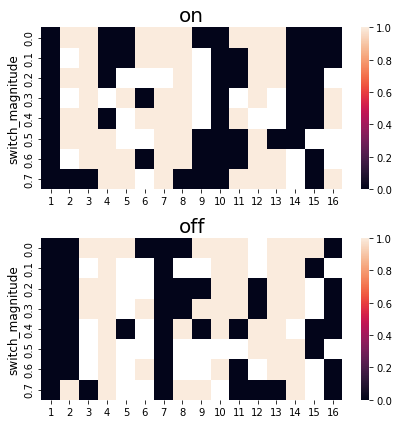

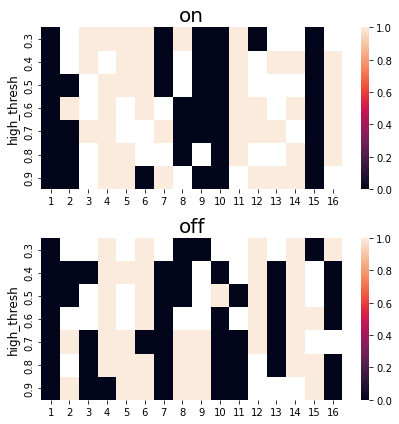

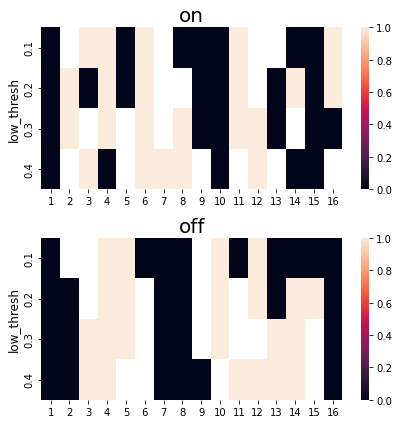

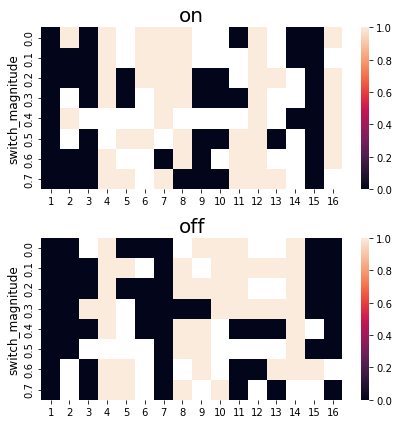

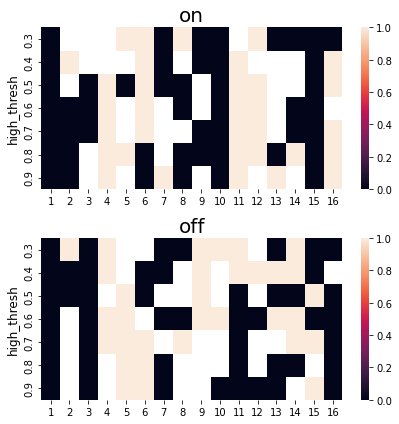

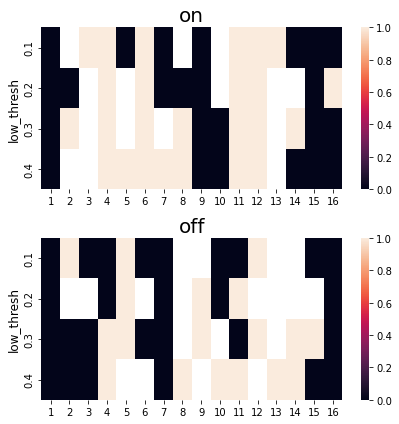

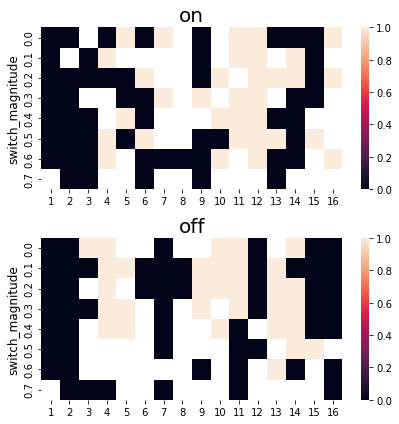

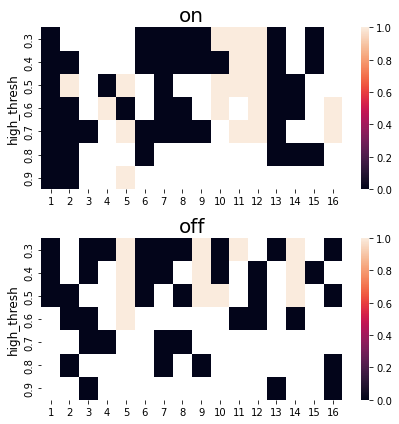

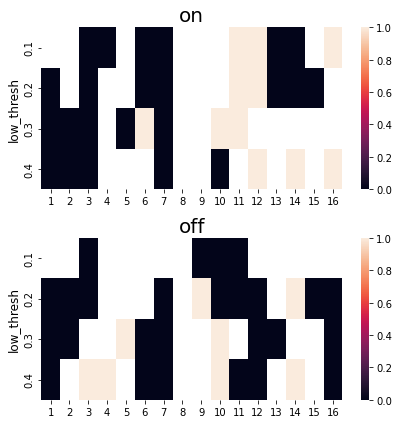

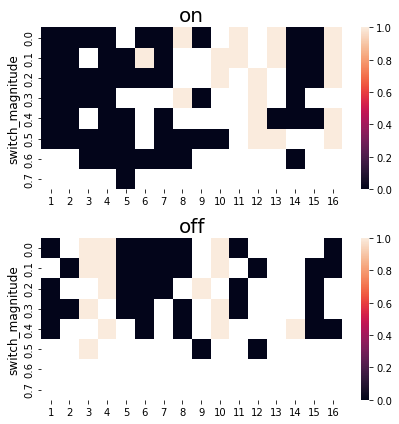

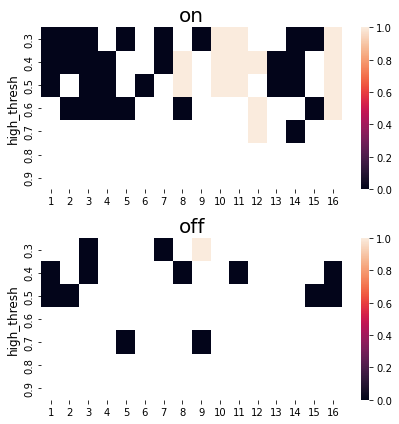

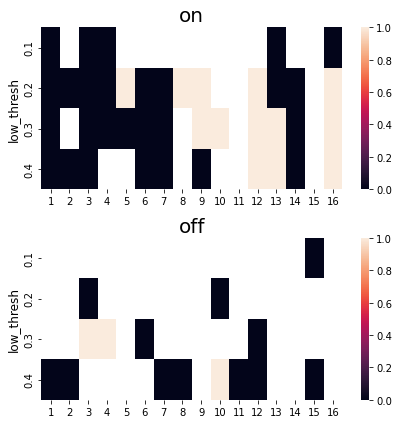

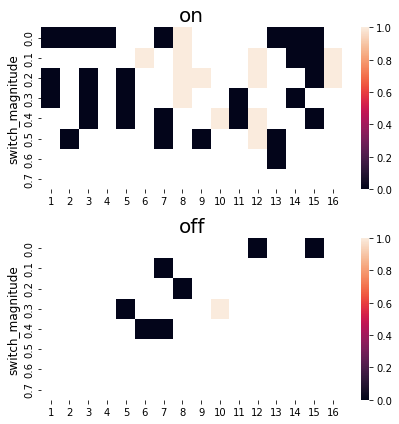

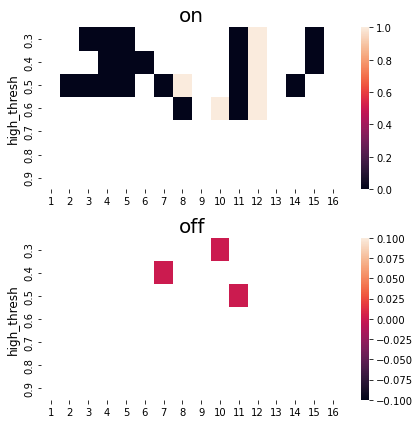

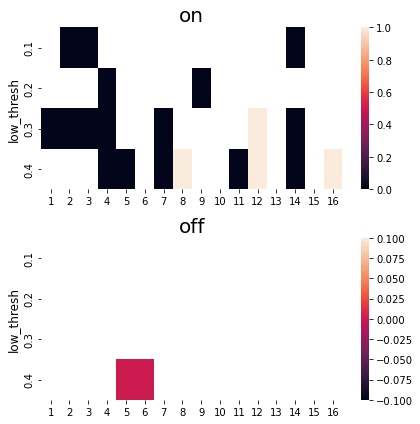

In [417]:
reload(cpa)
cdf_allpen,sig_allpen,sr_allpen,changes_df_allpen,fig_allpen = cpa.sweep_test_switch_ratio_multisweep_onetrialtype_multipreprocess(X_norm_pwc_d_allpen,(0,0),min_size,tosweep_key_l,tosweep_val_l,kwargs_l,detect_func=cpa.detect_switch_pwc,alpha=0.05,do_bonf=True,doplots=True,nrepeats=2)




In [462]:
cdf_alltrialtype

on                                          \
                                 1    2    3    4    5    6    7    8    9    
0 0.0 0.1 switch_magnitude 0.0  0.0  1.0  1.0  0.0  0.5  1.0  1.0  1.0  0.5   
                           0.1  0.0  1.0  1.0  0.0  0.5  0.5  1.0  1.0  0.5   
                           0.2  0.0  0.5  1.0  0.0  0.5  1.0  0.5  1.0  0.5   
                           0.3  0.0  1.0  1.0  0.0  0.5  1.0  1.0  1.0  0.0   
                           0.4  0.0  0.5  1.0  1.0  0.0  1.0  1.0  1.0  0.0   
...                             ...  ...  ...  ...  ...  ...  ...  ...  ...   
1 1.0 0.7 high_thresh      0.9  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5   
          low_thresh       0.1  0.5  0.5  0.0  0.0  0.5  0.5  0.5  0.5  0.5   
                           0.2  0.5  0.0  0.5  0.5  0.5  0.5  0.5  0.5  0.5   
                           0.3  0.0  0.0  0.5  0.0  0.5  0.5  0.5  1.0  0.5   
                           0.4  0.5  0.5  0.0  0.5  0.5  0.0  0.5  0.5  0.5   

                                     ...  off                            on  \
                                 10  ...   27   28   29   30   31   32   33   
0 0.0 0.1 switch_magnitude 0.0  0.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                           0.1  0.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                           0.2  0.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                           0.3  0.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                           0.4  0.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...                             ...  ...  ...  ...  ...  ...  ...  ...  ...   
1 1.0 0.7 high_thresh      0.9  0.5  ...  0.5  0.5  0.5  0.5  0.5  0.5  0.5   
          low_thresh       0.1  0.5  ...  0.5  0.5  0.5  0.5  0.5  0.5  0.5   
                           0.2  0.0  ...  0.5  0.5  0.5  0.5  0.5  0.5  0.5   
                           0.3  0.5  ...  0.0  0.5  0.5  0.5  0.5  0.5  0.5   
                           0.4  0.5  ...  0.5  0.5  0.5  0.5  0.5  0.5  0.5   

                                     off       
                                 34   33   34  
0 0.0 0.1 switch_magnitude 0.0  NaN  NaN  NaN  
                           0.1  NaN  NaN  NaN  
                           0.2  NaN  NaN  NaN  
                           0.3  NaN  NaN  NaN  
                           0.4  NaN  NaN  NaN  
...                             ...  ...  ...  
1 1.0 0.7 high_thresh      0.9  0.5  0.5  0.5  
          low_thresh       0.1  1.0  0.5  0.5  
                           0.2  0.5  0.5  0.5  
                           0.3  1.0  0.5  0.0  
                           0.4  1.0  0.5  0.5  

[380 rows x 68 columns]

In [464]:
from matplotlib.backends.backend_pdf import PdfPages

In [465]:
fig1 = plt.figure()
fig2 = plt.figure()
with PdfPages('test.pdf') as pdf:
    pdf.savefig(figure=fig1)
    pdf.savefig(figure=fig2)
plt.close(fig1)
plt.close(fig2)

In [463]:
fig_alltrialtype

{(0,
  0.0): {0.1: {'switch_magnitude': <Figure size 864x432 with 8 Axes>,
   'high_thresh': <Figure size 864x432 with 8 Axes>,
   'low_thresh': <Figure size 864x432 with 8 Axes>}, 0.2: {'switch_magnitude': <Figure size 864x432 with 8 Axes>,
   'high_thresh': <Figure size 864x432 with 8 Axes>,
   'low_thresh': <Figure size 864x432 with 8 Axes>}, 0.4: {'switch_magnitude': <Figure size 864x432 with 8 Axes>,
   'high_thresh': <Figure size 864x432 with 8 Axes>,
   'low_thresh': <Figure size 864x432 with 8 Axes>}, 0.5: {'switch_magnitude': <Figure size 864x432 with 8 Axes>,
   'high_thresh': <Figure size 864x432 with 8 Axes>,
   'low_thresh': <Figure size 864x432 with 8 Axes>}, 0.7: {'switch_magnitude': <Figure size 864x432 with 8 Axes>,
   'high_thresh': <Figure size 864x432 with 8 Axes>,
   'low_thresh': <Figure size 864x432 with 8 Axes>}},
 (0,
  1.0): {0.1: {'switch_magnitude': <Figure size 864x432 with 8 Axes>,
   'high_thresh': <Figure size 864x432 with 8 Axes>,
   'low_thresh': <Figu

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
/mnt/home/szheng/projects/nmf_analysis/change_point_plot.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axs = plt.subplots(len(keys),2,figsize=(6*2,3*len(keys)),sharey=False)
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vm

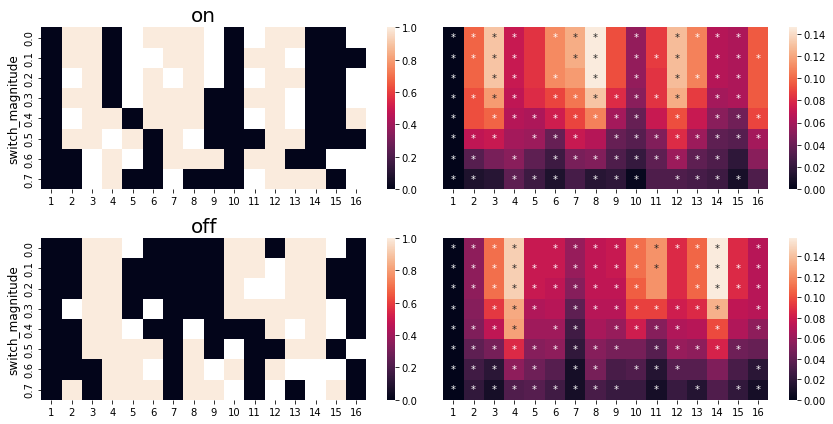

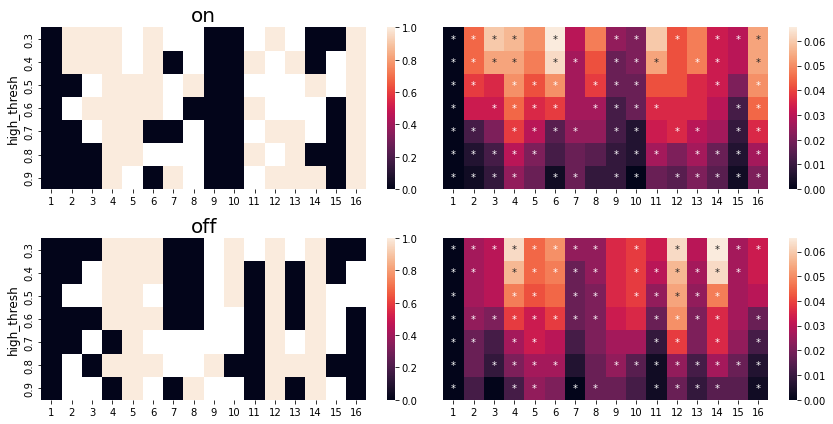

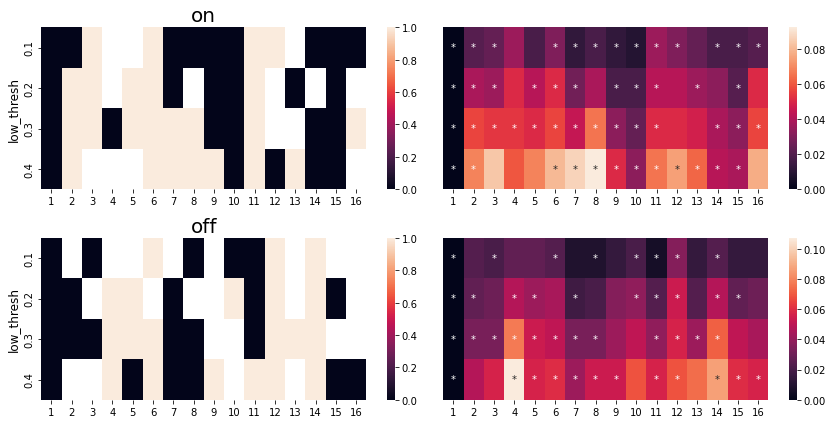

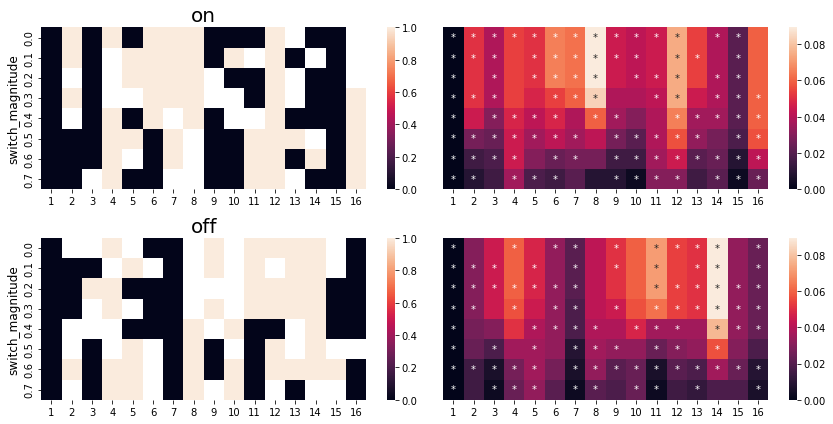

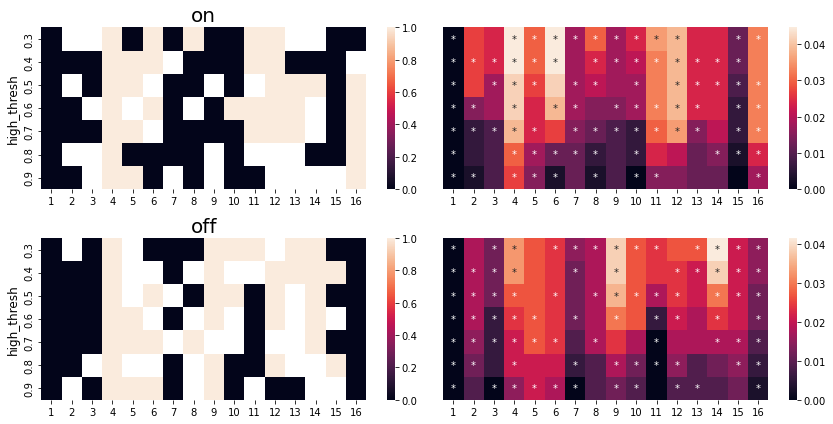

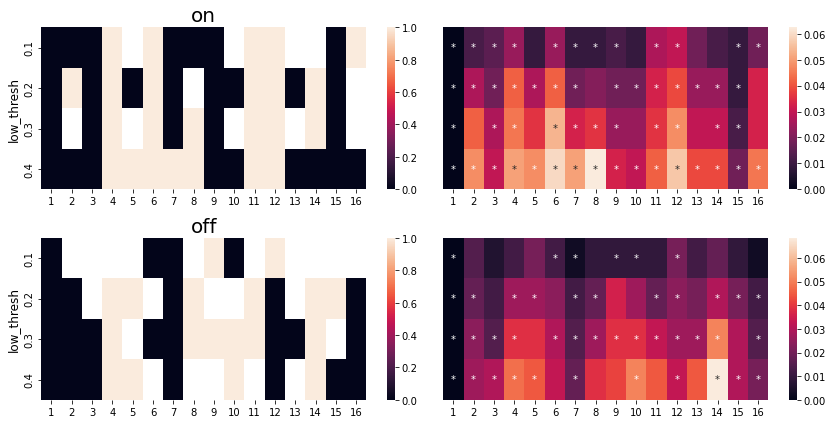

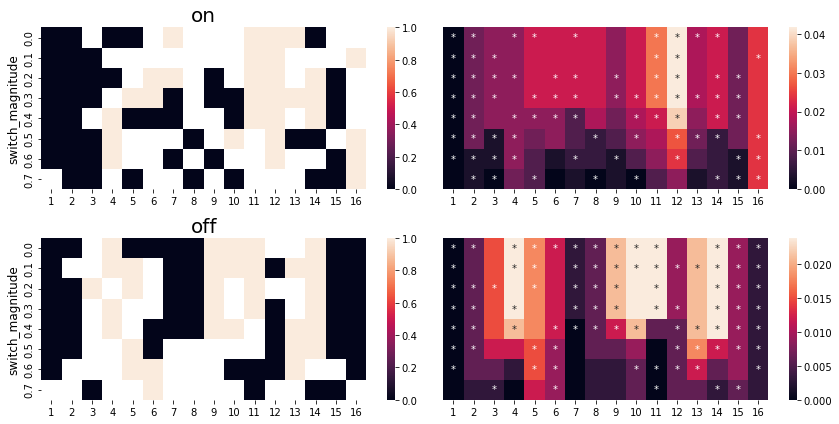

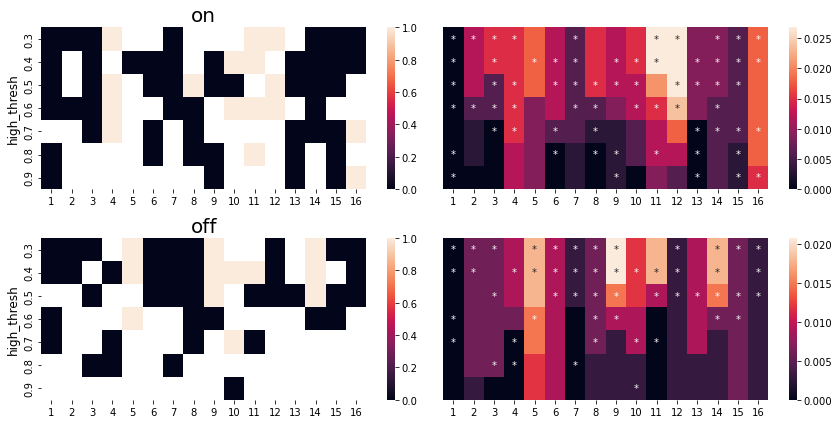

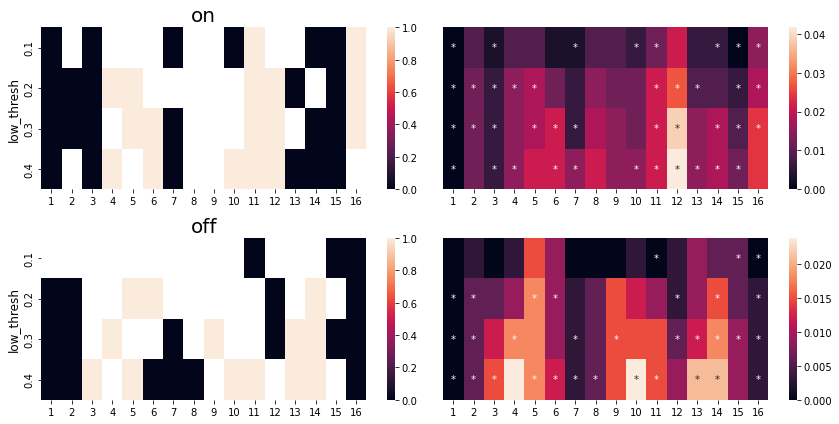

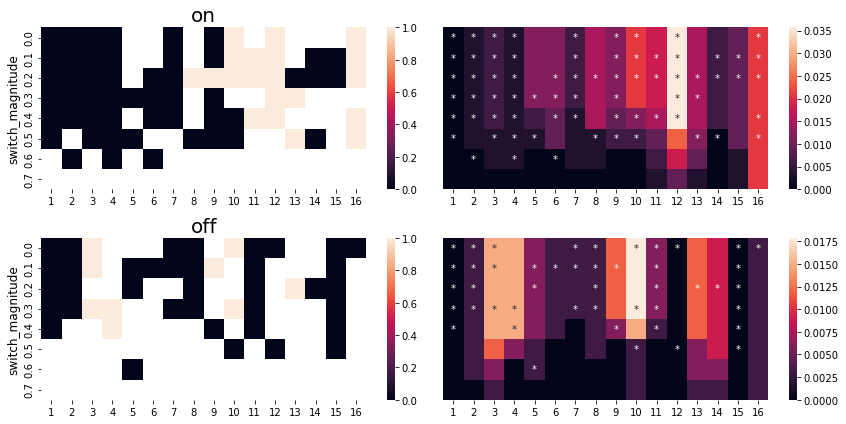

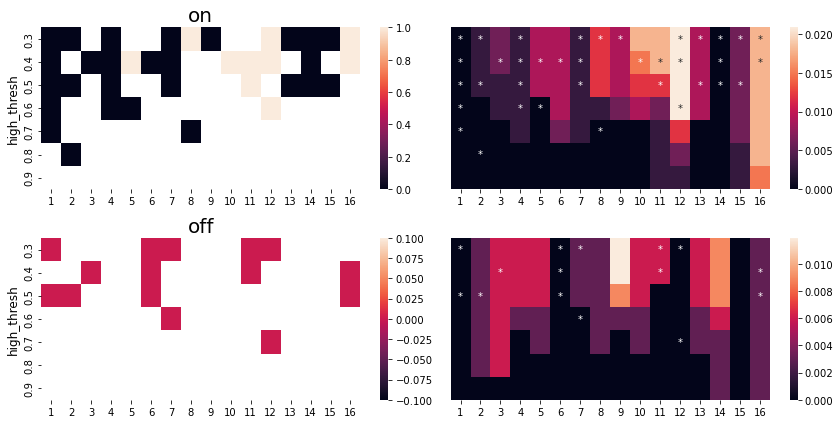

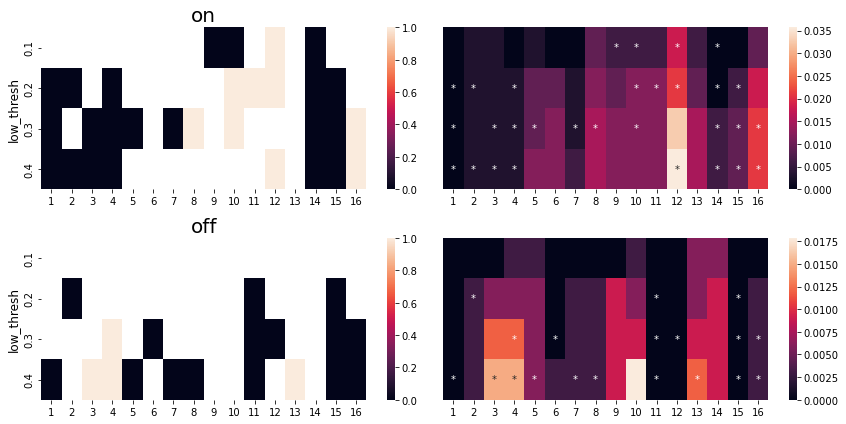

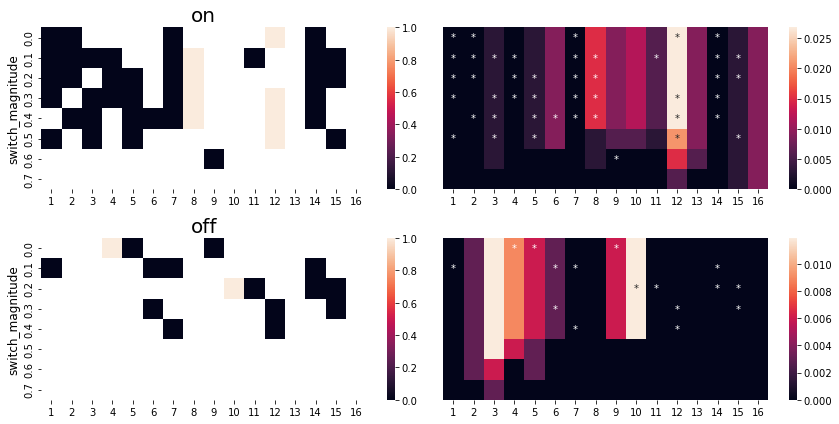

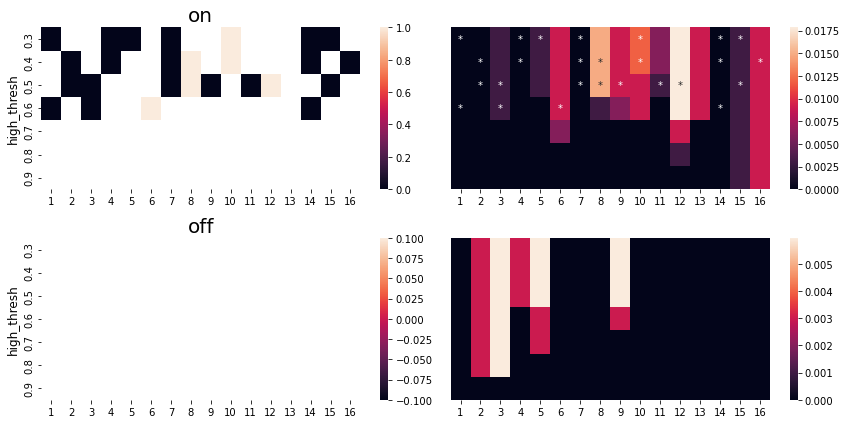

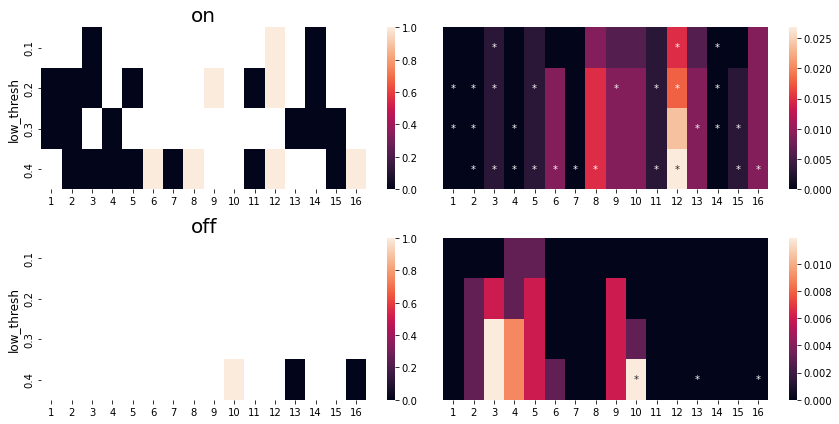

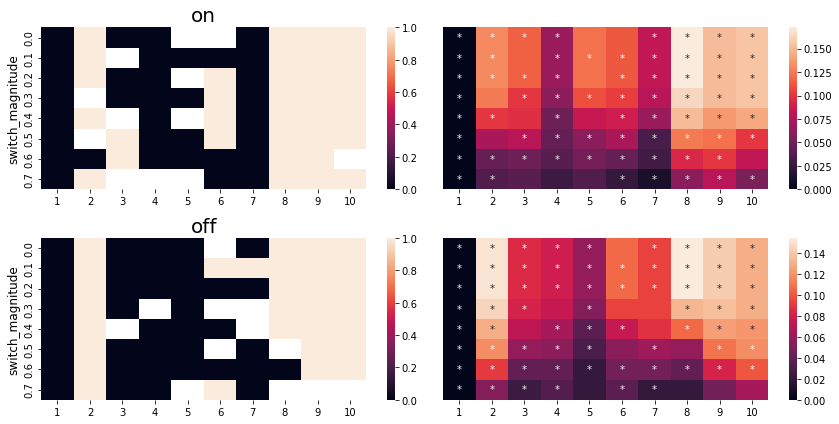

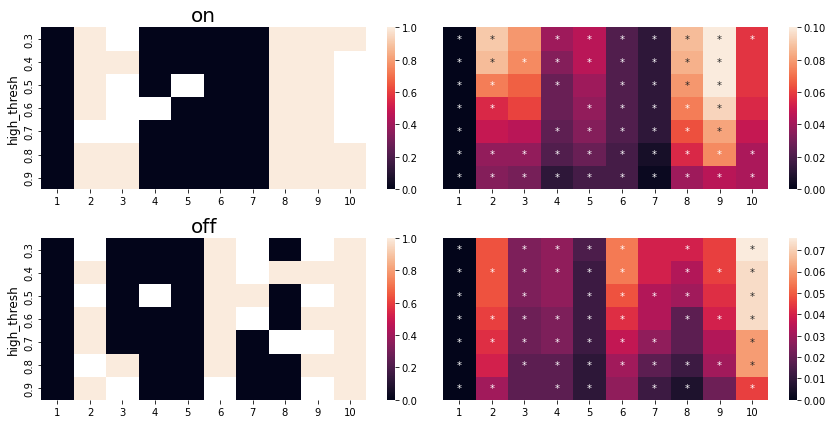

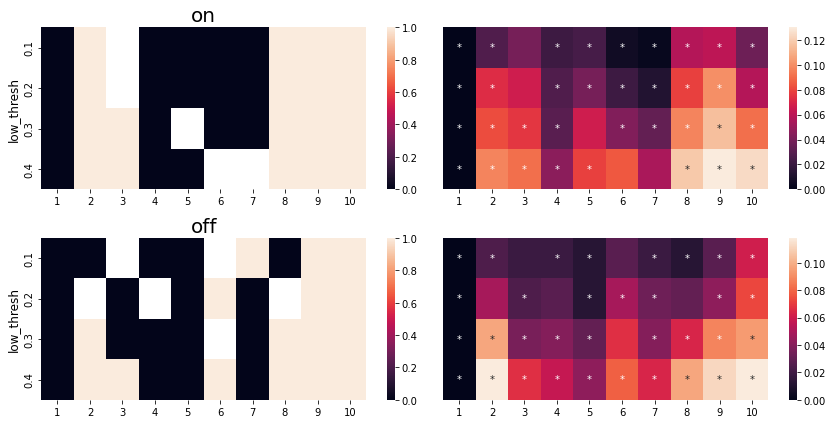

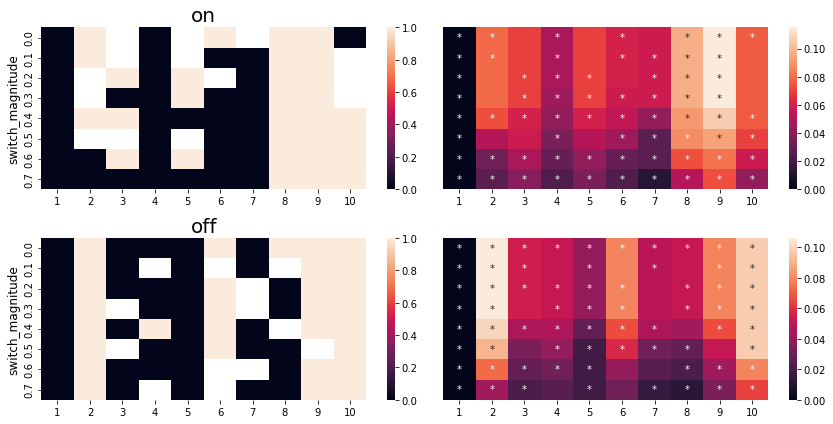

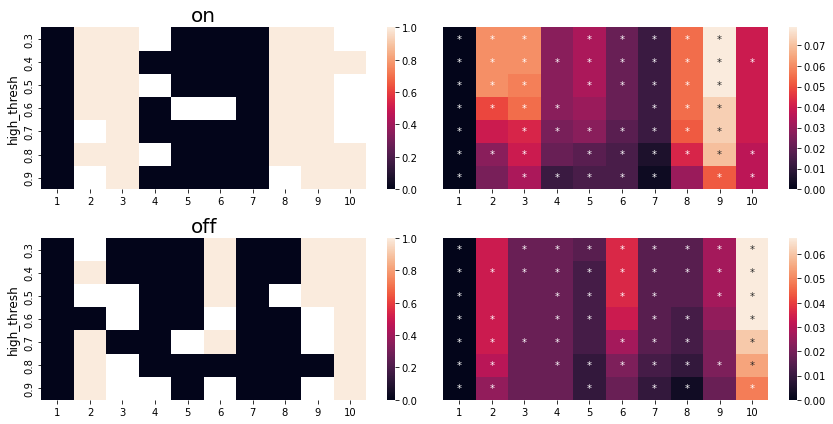

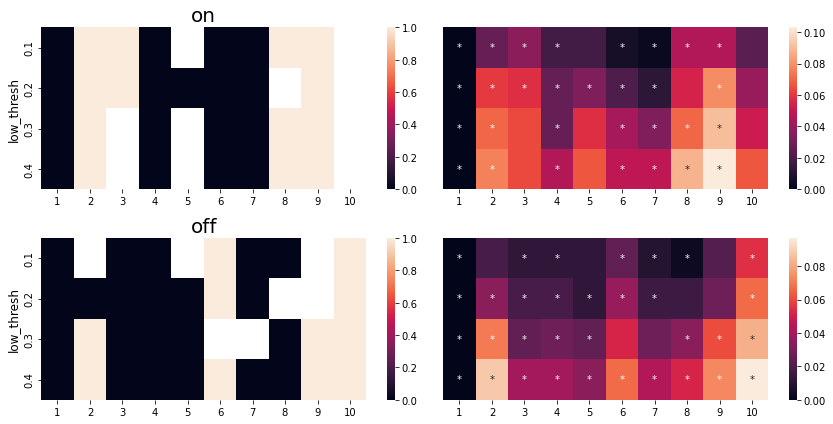

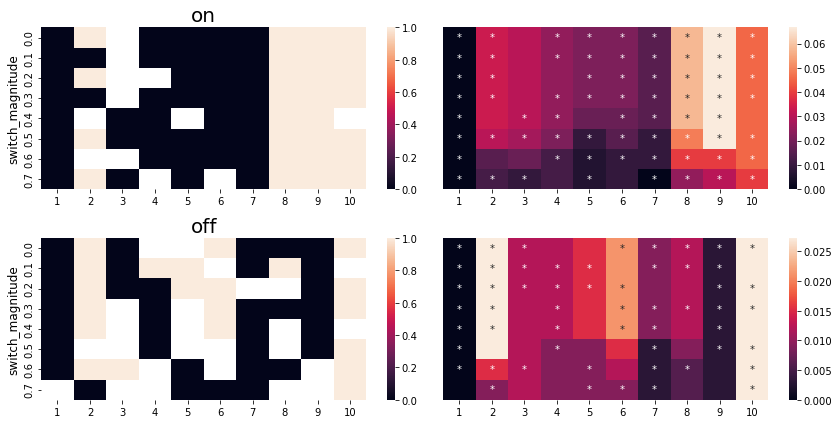

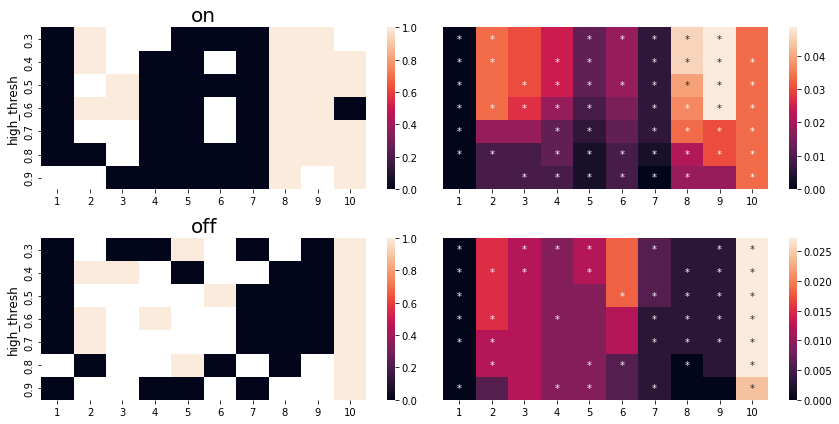

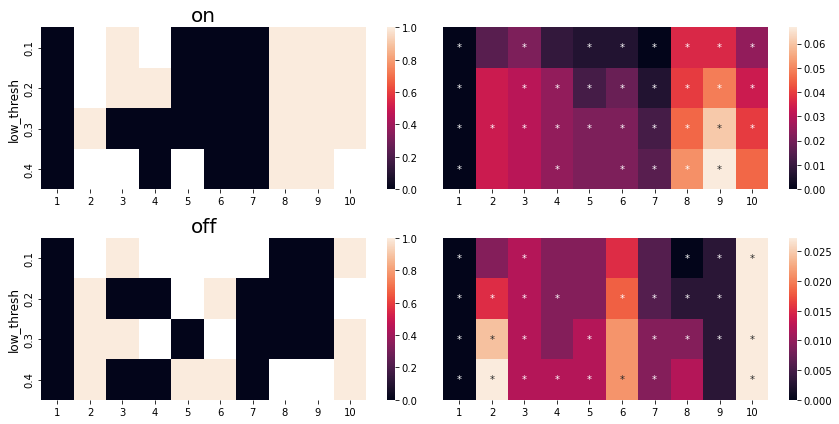

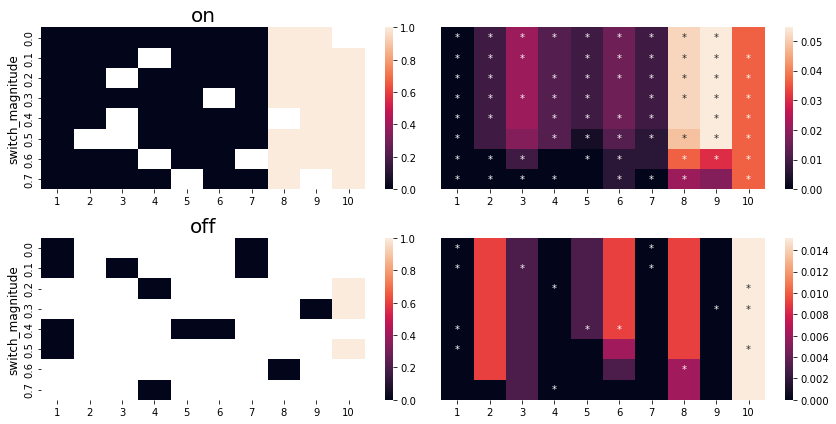

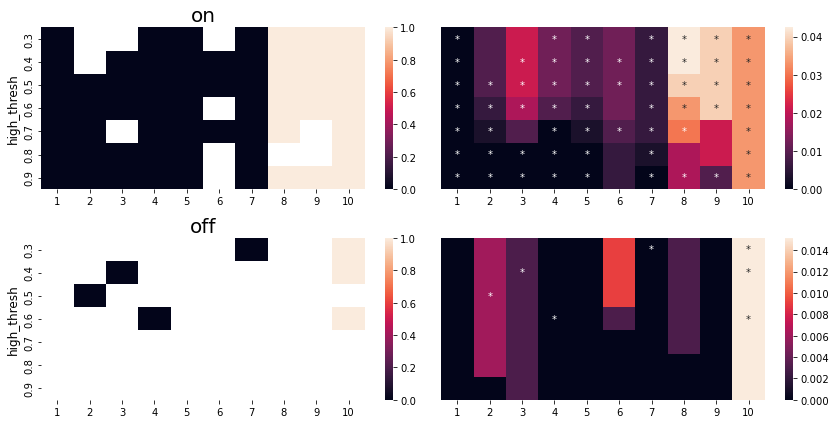

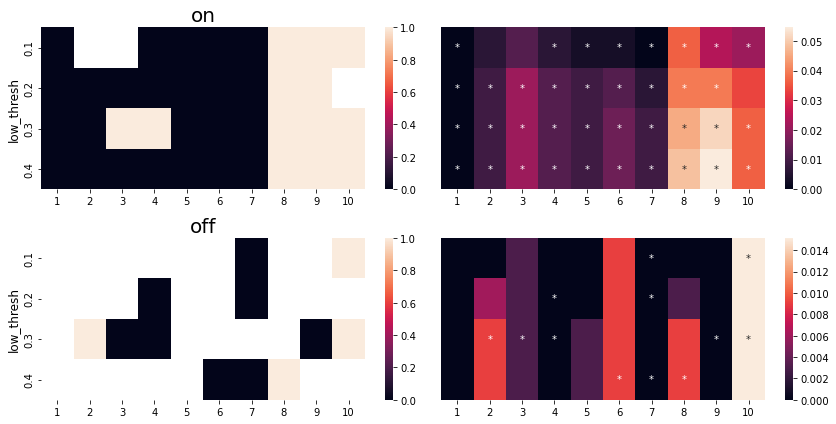

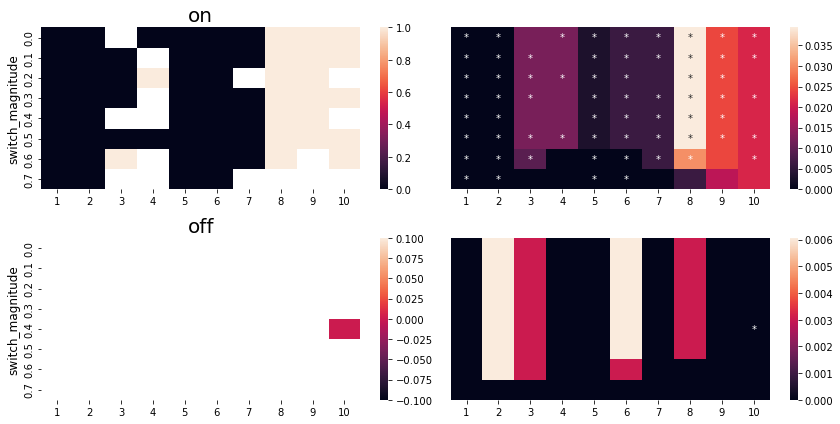

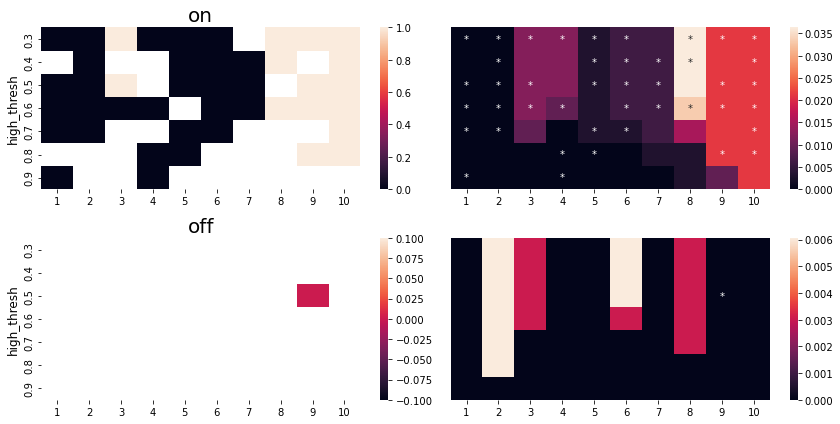

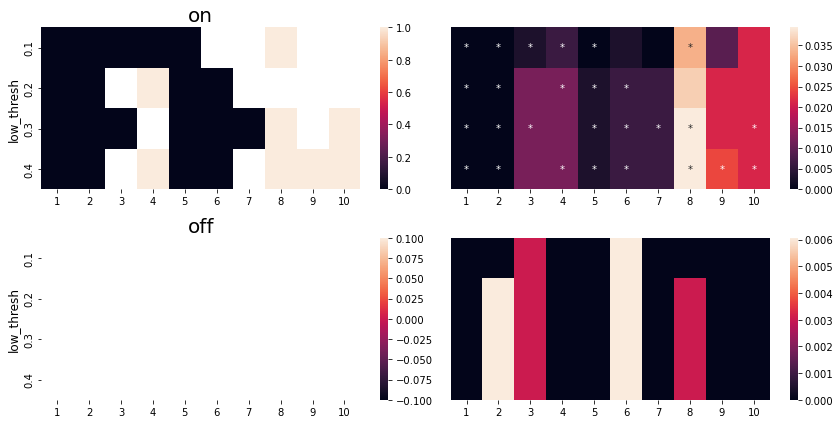

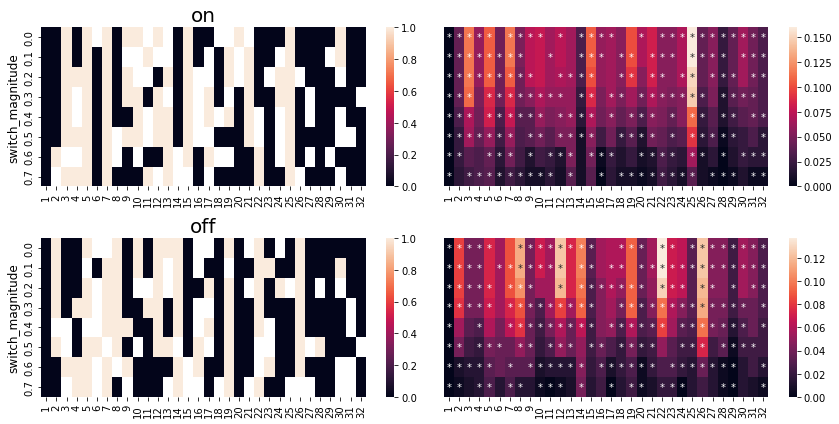

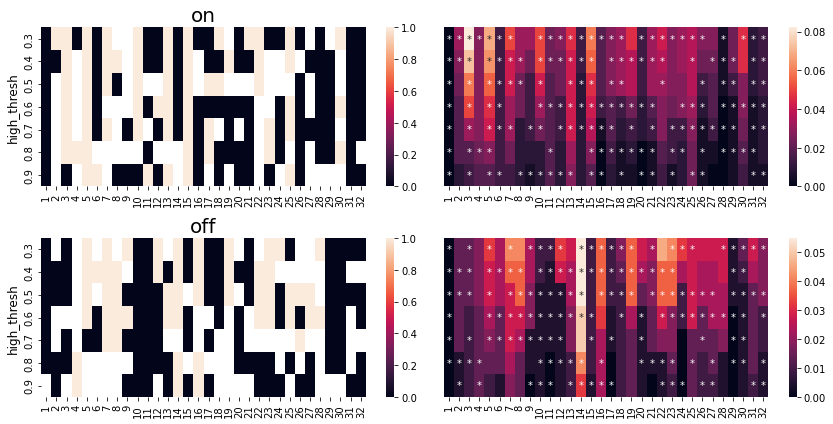

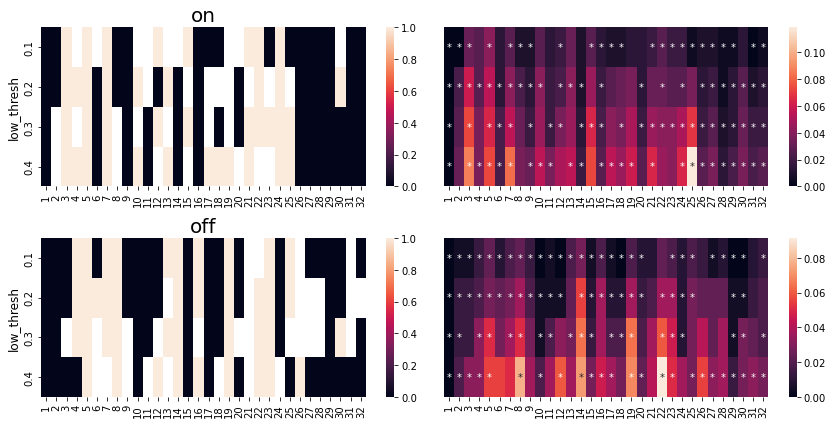

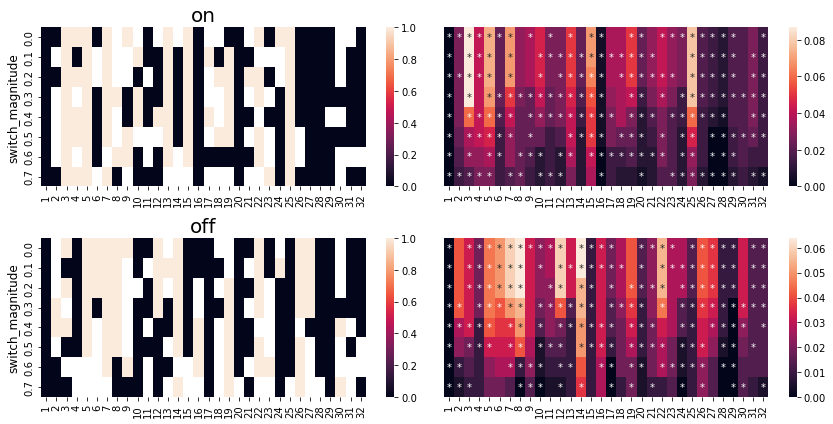

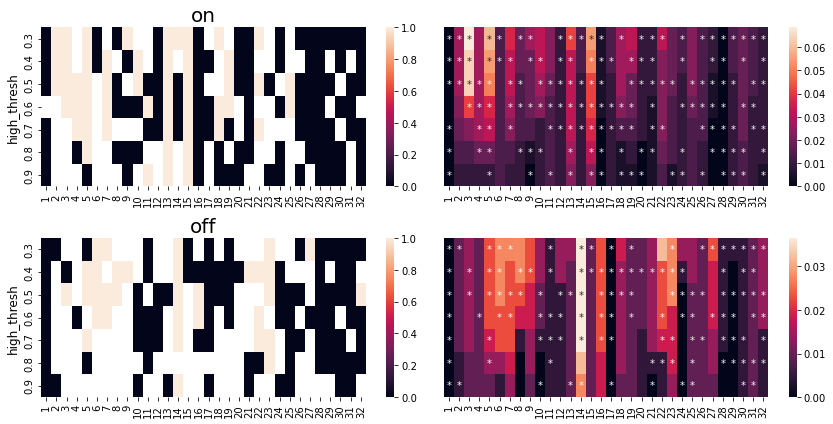

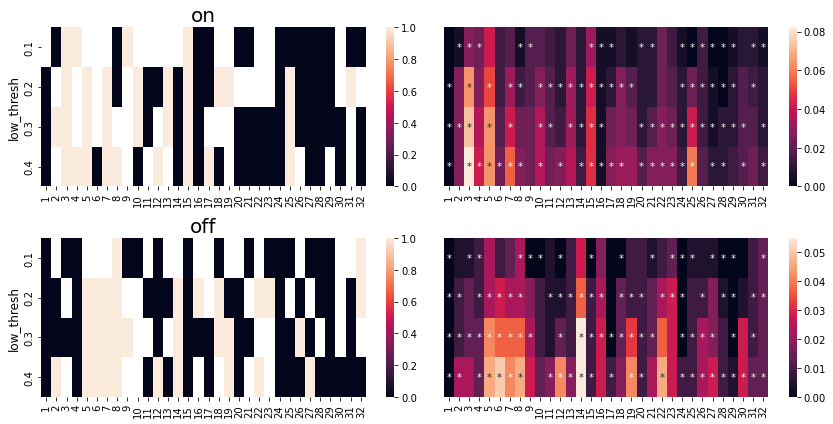

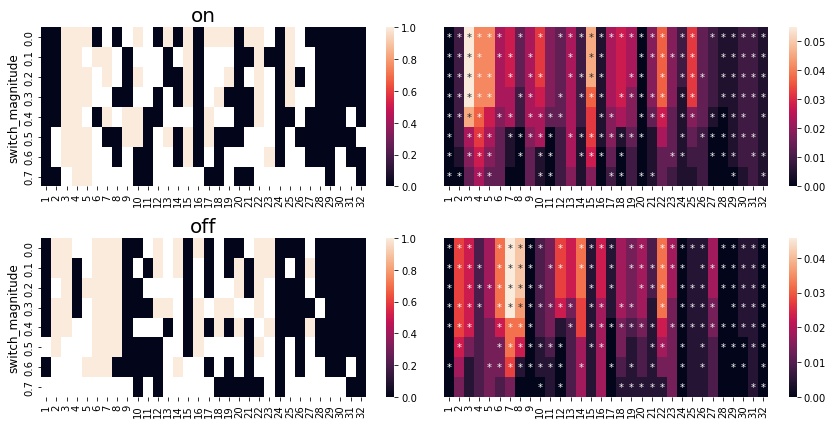

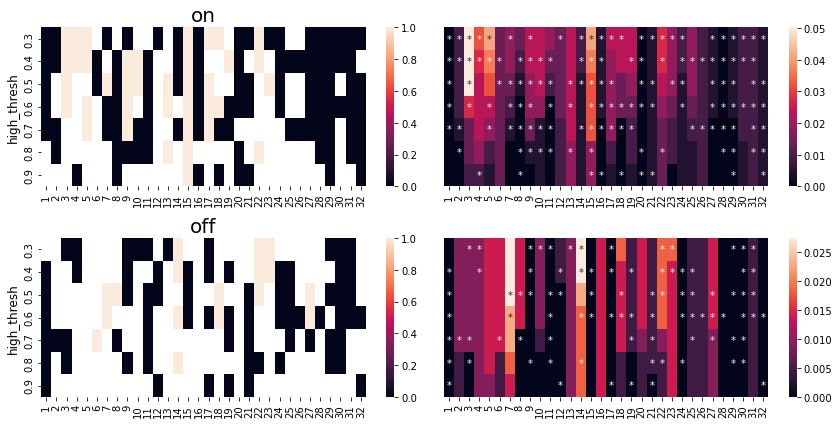

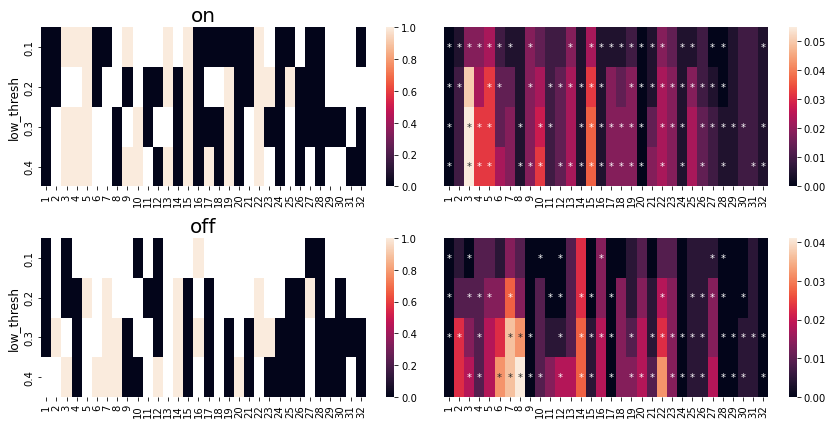

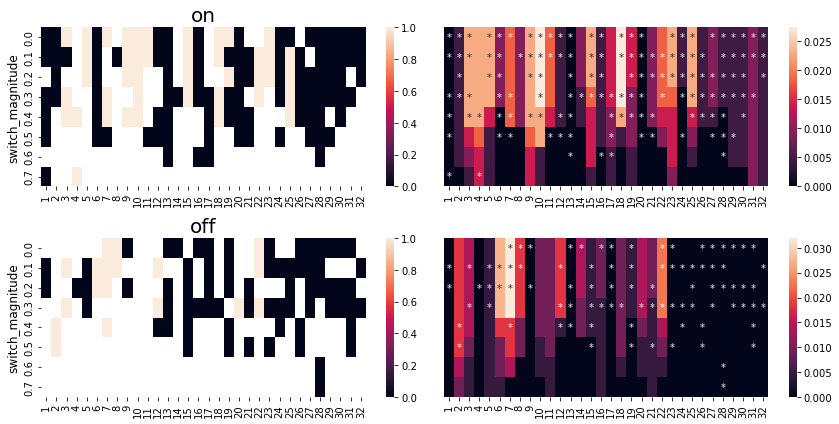

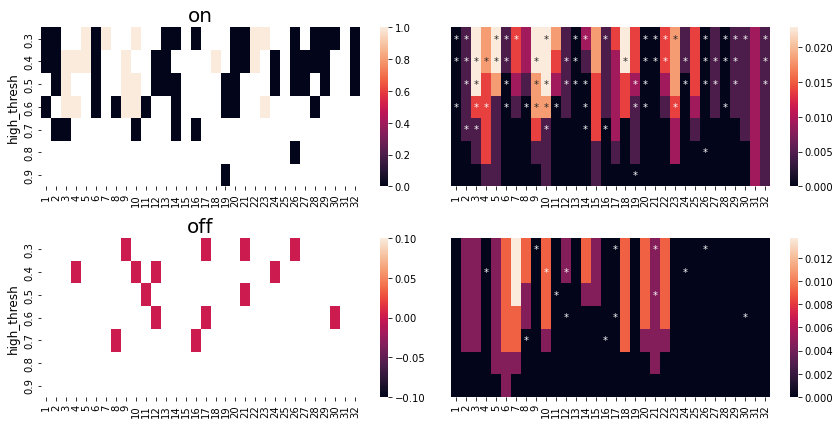

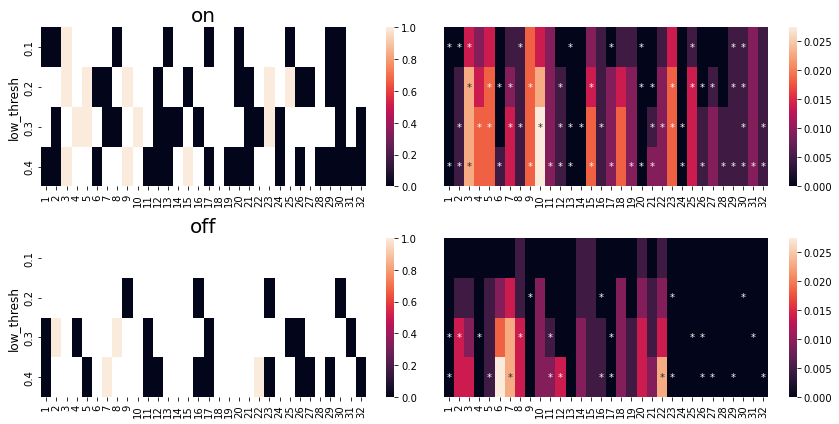

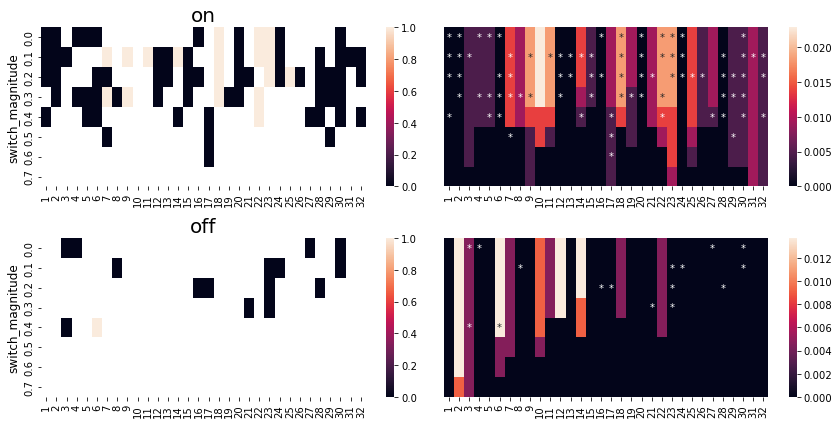

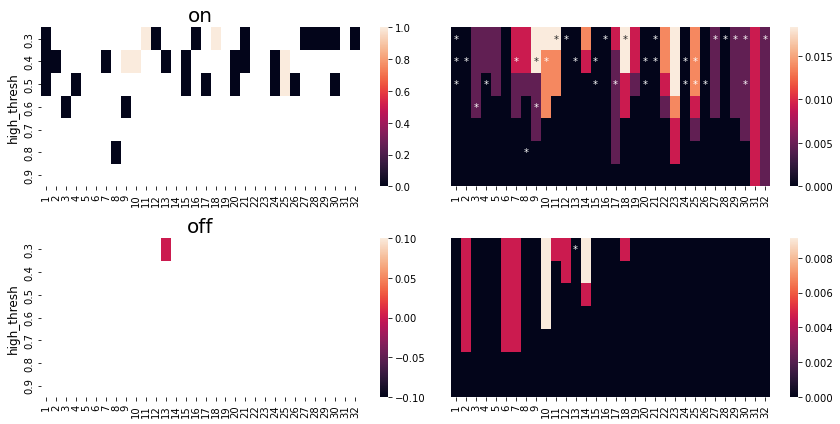

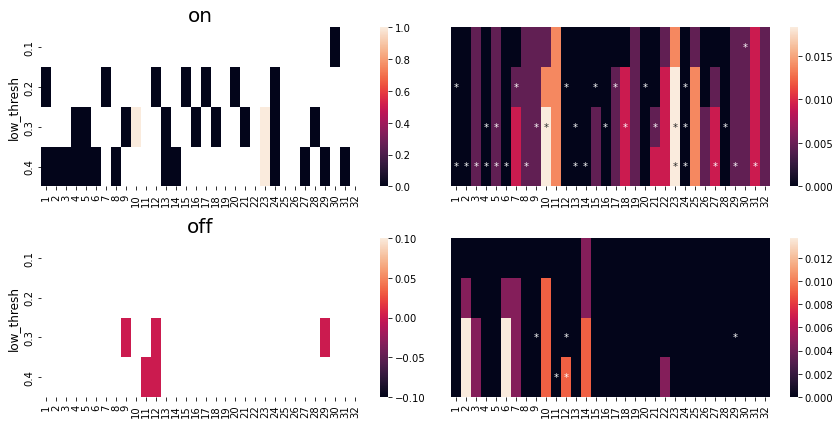

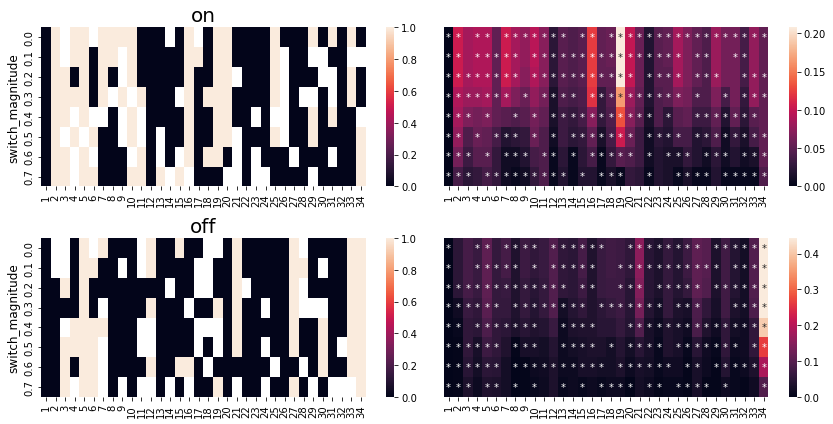

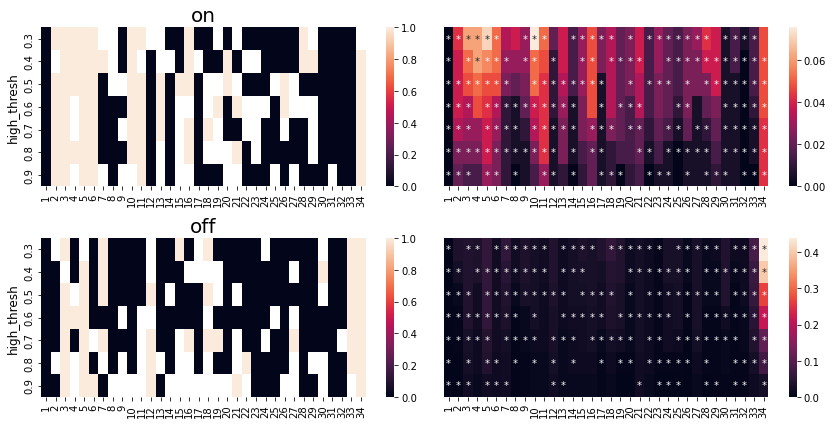

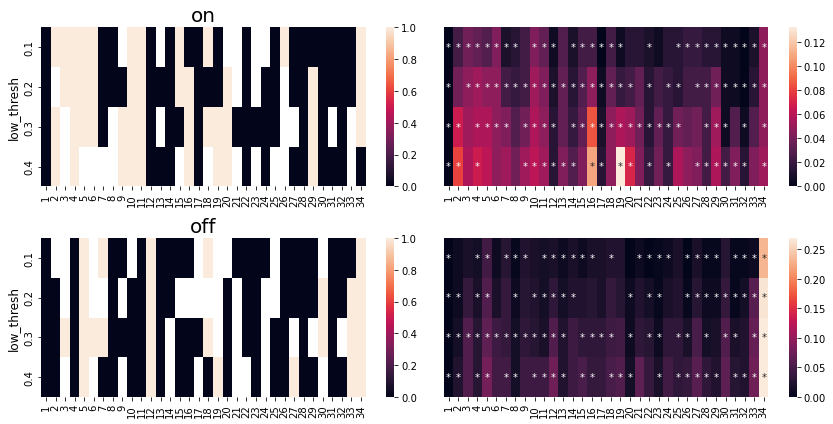

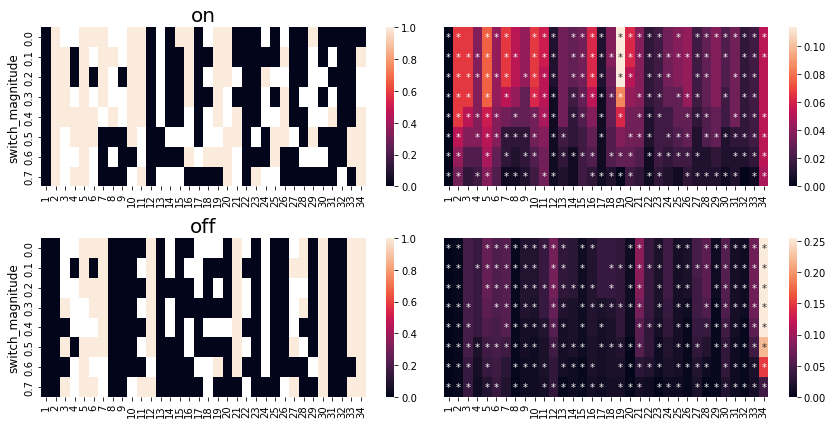

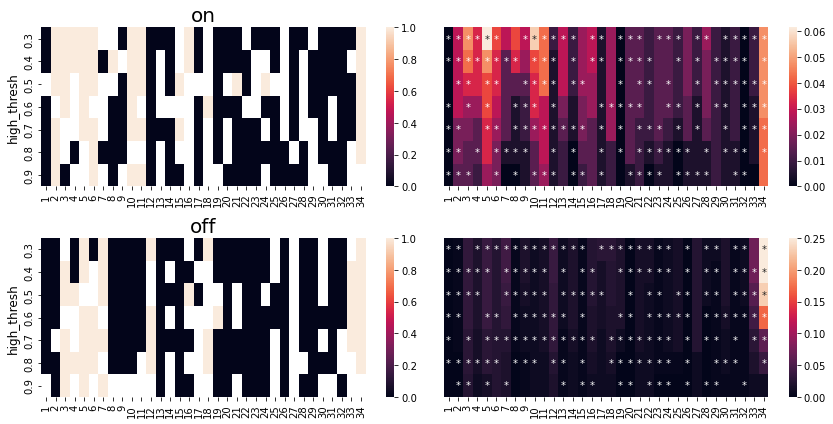

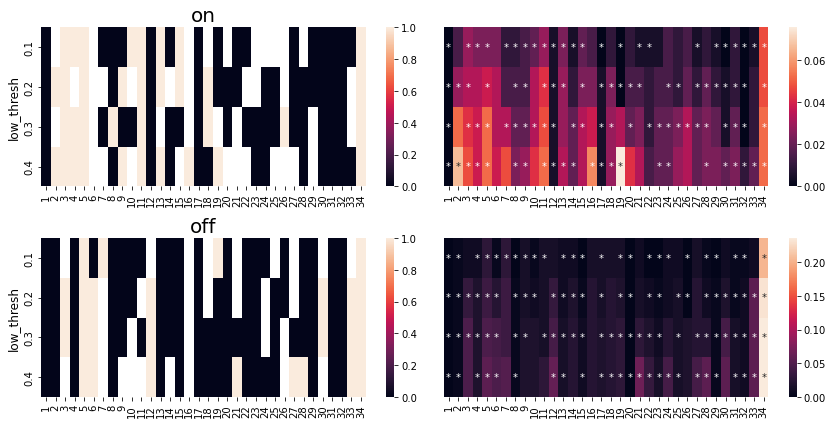

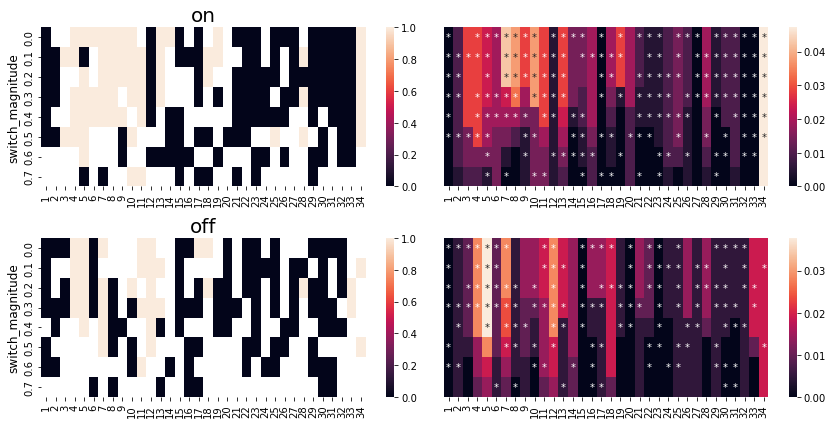

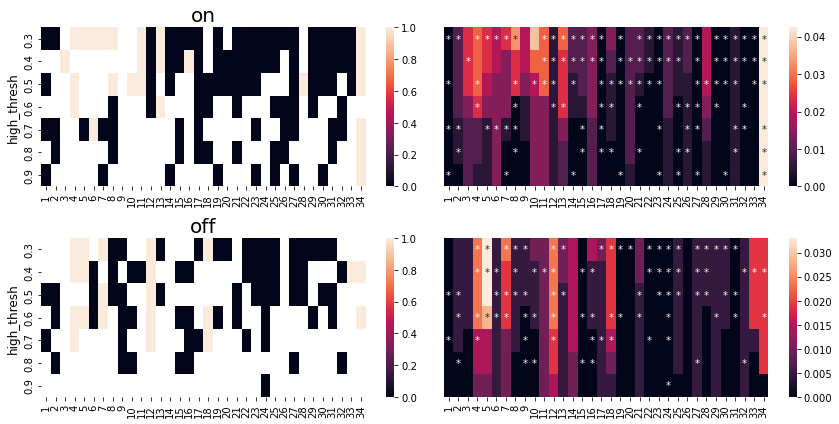

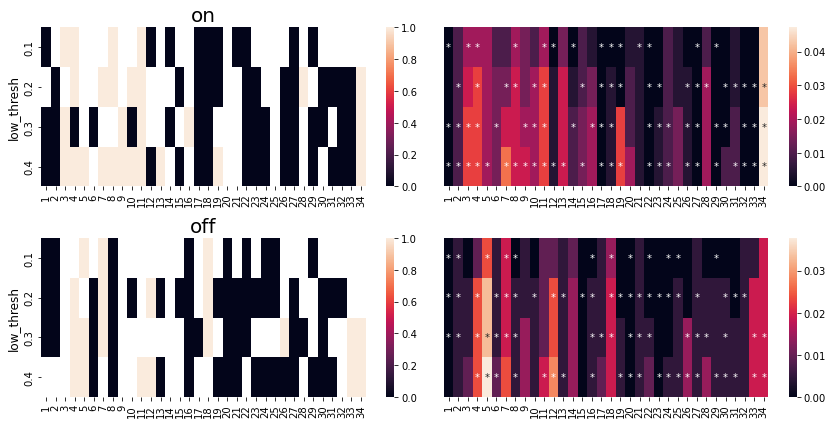

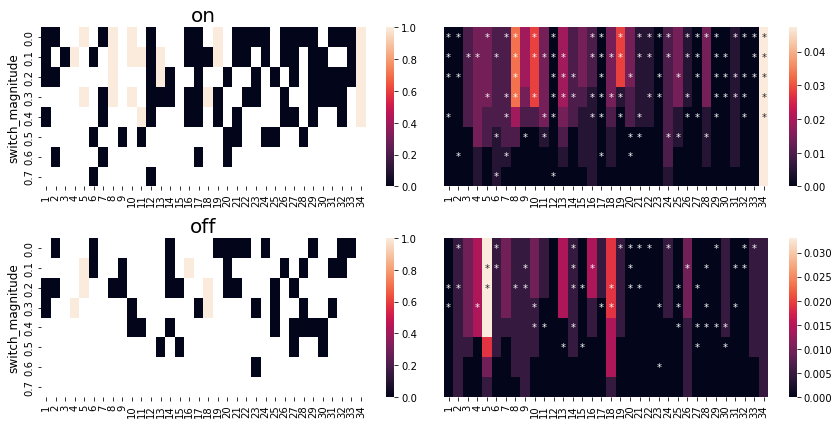

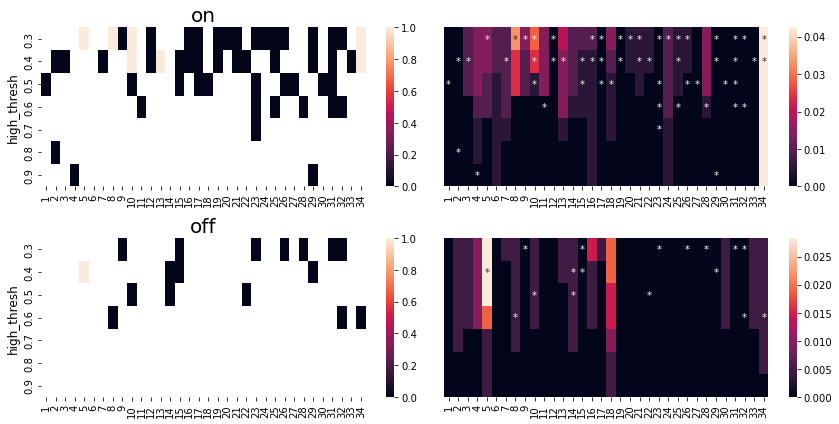

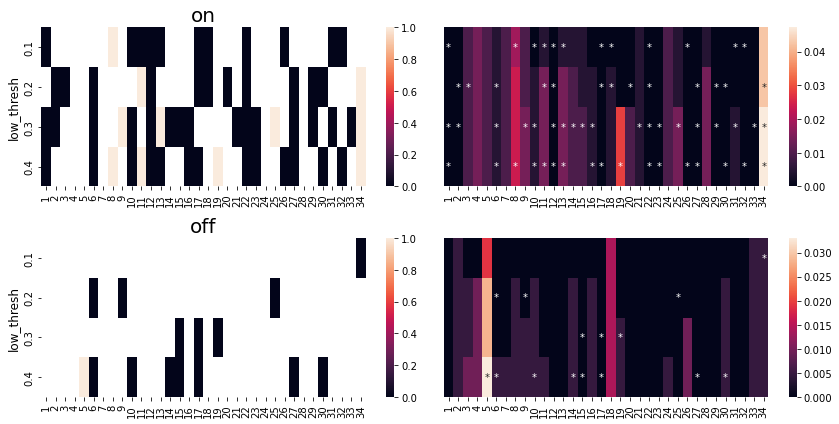

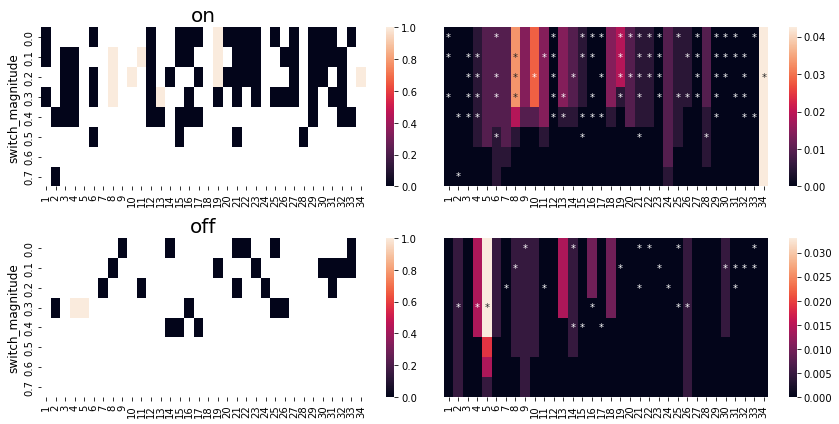

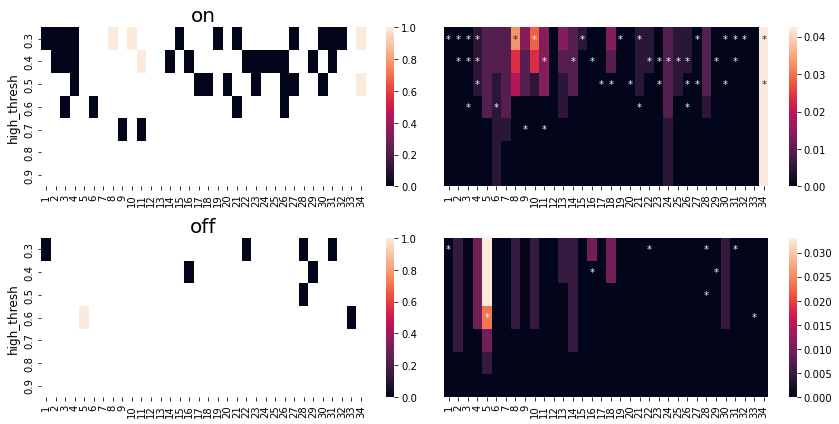

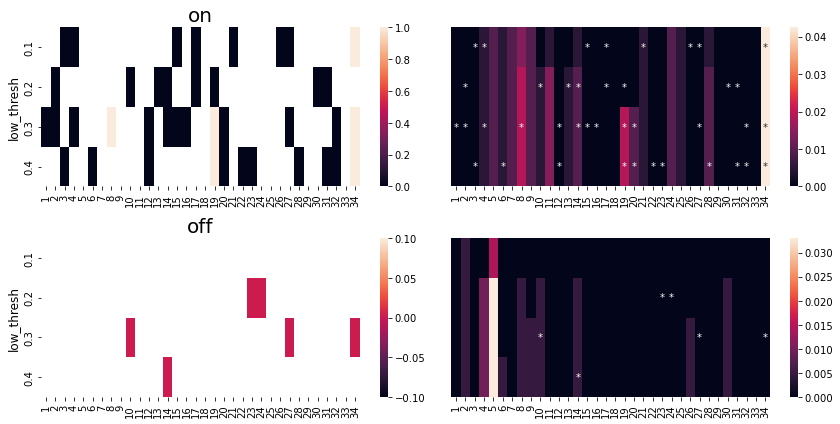

In [461]:
reload(cpa)
cdf_alltrialtype,sig_alltrialtype,sr_alltrialtype,changes_df_alltrialtype,fig_alltrialtype = cpa.sweep_test_switch_ratio_multisweep_alltrialtype_multipreprocess(X_norm_pwc_d_allpen,min_size,tosweep_key_l,tosweep_val_l,kwargs_l,detect_func=cpa.detect_switch_pwc,alpha=0.05,do_bonf=True,doplots=True,nrepeats=2)



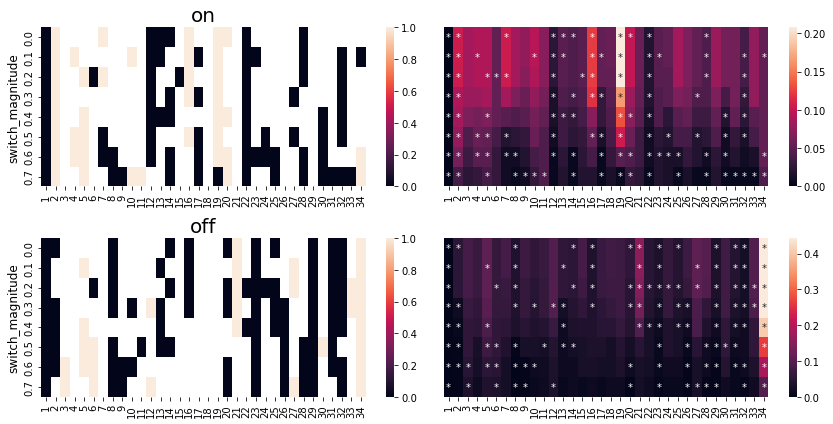

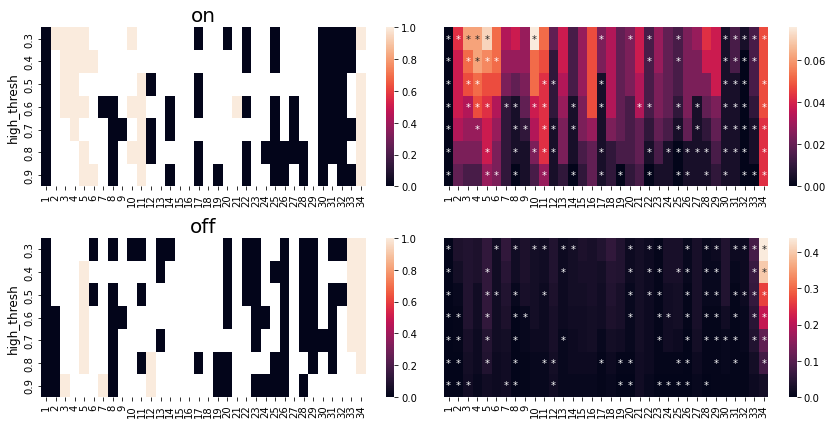

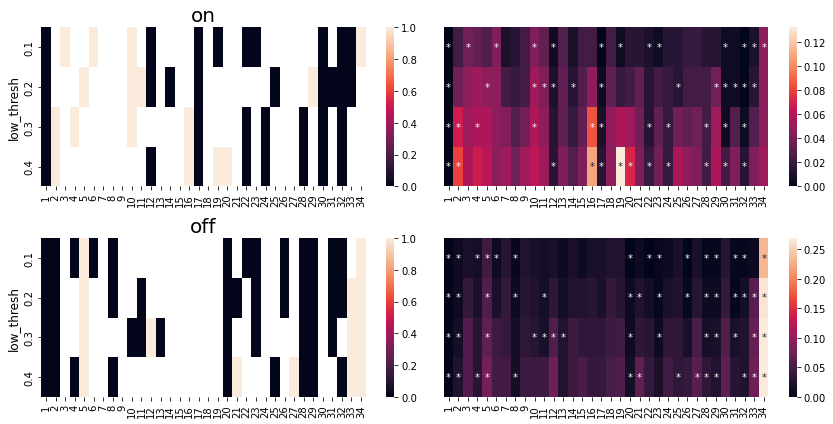

In [452]:
reload(cpa)
cdf_alltosweep_key,sig_alltosweep_key,sr_alltosweep_key,changes_df_alltosweep_key,fig_alltosweep_key = cpa.sweep_test_switch_ratio_multisweep_onetrialtype(X_norm_pwc,min_size,tosweep_key_l,tosweep_val_l,kwargs_l,detect_func=cpa.detect_switch_pwc,alpha=0.05,do_bonf=True,doplots=True,nrepeats=10)



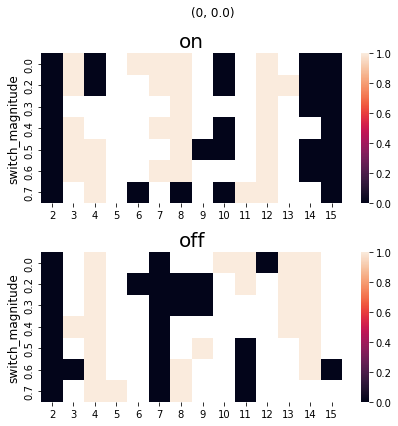

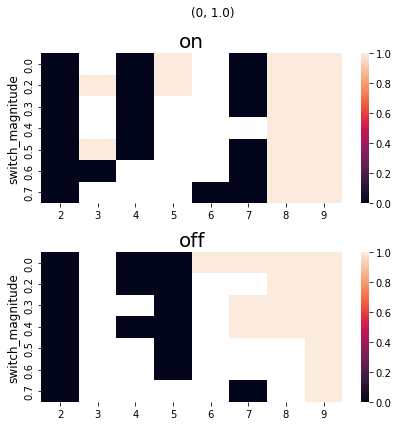

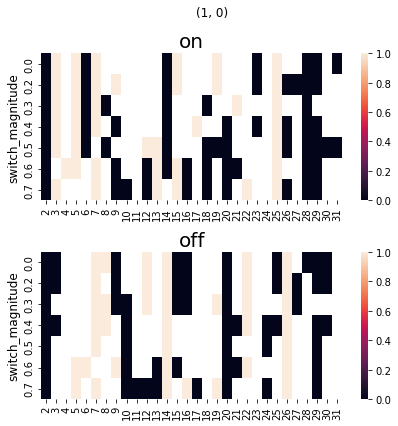

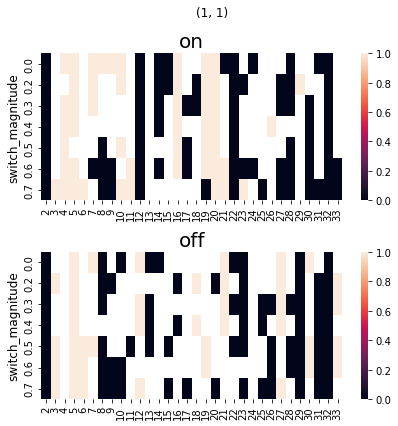

In [376]:
reload(cpa)
tosweep_key = 'switch_magnitude'
tosweep_val = [0,0.2,0.3,0.4,0.5,0.6,0.7]
kwargs = dict(low_thresh=1,high_thresh=0)
cdf_alltrialtype,sig_alltrialtype,sr_alltrialtype,changes_df_alltrialtype,fig_alltrialtype = cpa.sweep_test_switch_ratio_alltrialtype(X_norm_pwc_d_allpen[0.1],2,tosweep_key,tosweep_val,detect_func=cpa.detect_switch_pwc,alpha=0.05,do_bonf=False,doplots=doplots,nrepeats=5,**kwargs)




In [374]:
X_norm_pwc_d_allpen[0.1]

{(0,
  0.0):              0         1         2         3         4         5         6   \
 1   0  0.007401  0.007401  0.007401  0.007401  0.007401  0.007401  0.007401   
 39  0  0.773384  0.773384  0.773384  0.773384  0.773384  0.773384  0.773384   
 40  0  0.307515  0.307515  0.307515  0.307515  0.307515  1.000000  0.390087   
     1  0.358263  0.358263  0.358263  0.358263  0.358263  0.358263  0.358263   
 42  0  0.727568  0.727568  0.727568  0.727568  0.727568  0.727568  0.727568   
 ...         ...       ...       ...       ...       ...       ...       ...   
 358 0  0.032929  0.032929  0.032929  0.032929  0.032929  0.032929  0.032929   
     1  0.212075  0.212075  0.212075  0.212075  0.212075  0.212075  0.212075   
 359 0  0.459386  0.459386  0.459386  1.000000  0.362776  0.362776  0.362776   
 360 0  0.030578  0.030578  0.030578  1.000000  0.137966  0.137966  0.137966   
 361 0  0.000000  0.000000  0.000000  0.000000  0.000000  1.000000  0.002362   
 
              7         8 

In [241]:
X_norm = X_all[key] / X_all[key].max(axis=1).values[:,None]

In [475]:
changes_df_alltrialtype.loc[(*(0,1),0.1)]

1   2   3   4   5   6   7   8   9   10  ...  25  \
switch_magnitude 0.0 1   0   0   0   0   0   0   0   0   0   0   0  ... NaN   
                     40  0   0   1   0   0   0   0   0  -1   0   0  ... NaN   
                     46  0   0   0   1  -1   0   0   0   1  -1   0  ... NaN   
                         1   0  -1   0   0   0   0   0   0   0   0  ... NaN   
                         2   0   0   0   0   0   0   0  -1   1   0  ... NaN   
...                         ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..   
low_thresh       0.4 359 1   0   0   0   0   0   0   0   0   1   0  ... NaN   
                     360 0   0   0   0   0   0   0   0   0   0   1  ... NaN   
                     361 0   0   0   0   1  -1   0   0   0   0   0  ... NaN   
                         1   0   0   0   0   0   1  -1   0   0   0  ... NaN   
                     362 0   0   0   0   0   0   0   0   0   1   0  ... NaN   

                            26  27  28  29  30  31  32  33  34  
switch_magnitude 0.0 1   0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
                     40  0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
                     46  0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
                         1 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
                         2 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
...                         ..  ..  ..  ..  ..  ..  ..  ..  ..  
low_thresh       0.4 359 1 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
                     360 0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
                     361 0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
                         1 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
                     362 0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[6270 rows x 34 columns]

In [240]:
reload(cpa)
inds_d = cpa.get_inds_switch_sametrial_sorted(changes_df_d.loc[0.6])

In [485]:
reload(dpp)

<module 'data_prep_pyn' from '/mnt/home/szheng/projects/util_code/data_prep_pyn.py'>

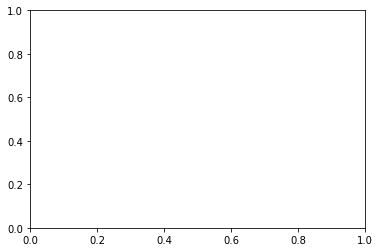

In [500]:
fig,ax=plt.subplots(1)

In [501]:
ax=np.array([ax])

In [504]:
ax.ravel()[0]

<AxesSubplot:>

In [512]:
del saos
reload(cpp)

<module 'change_point_plot' from '/mnt/home/szheng/projects/nmf_analysis/change_point_plot.py'>

In [513]:
import switch_analysis_one_session as saos
reload(saos)
saos.switch_analysis_one_session(data_dir_full,speed_thresh = 1,doplots=True,force_reload=False,nrepeats = 2)

<module 'sys' (built-in)>
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m1/e16_2m1_201116/py_data/switch_analysis/switch_res.p exists, loading--!


/mnt/home/szheng/projects/nmf_analysis/scripts/switch_analysis_one_session.py:186: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes=res_to_save_data['changes_df'].loc[(*trialtype,pen,tosweep_key,tosweep_val),:]
/mnt/home/szheng/projects/nmf_analysis/scripts/switch_analysis_one_session.py:186: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes=res_to_save_data['changes_df'].loc[(*trialtype,pen,tosweep_key,tosweep_val),:]
/mnt/home/szheng/projects/nmf_analysis/scripts/switch_analysis_one_session.py:186: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes=res_to_save_data['changes_df'].loc[(*trialtype,pen,tosweep_key,tosweep_val),:]
/mnt/home/szheng/projects/nmf_analysis/scripts/switch_analysis_one_session.py:186: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes=res_to_save_data['changes_df'].loc[(*trialtype,pen,tosweep_key,tosweep_val),:]
/mnt/home/szheng/project

{'X': {'raw': {(0,
    0.0):              0         1         2         3         4         5         6
   4  0  0.525998  0.265130  0.709527  0.678676  1.000000  0.510034  0.572070
      1  0.431512  0.440252  0.723318  1.000000  0.785643  0.746599  0.313053
   5  0  1.000000  0.980538  0.377096  0.479245  0.703601  0.469650  0.416941
   7  0  0.519161  0.704004  0.565812  0.559666  1.000000  0.455145  0.451844
   10 0  0.505032  0.942387  1.000000  0.612188  0.685109  0.547144  0.896154
      1  0.505032  0.942387  1.000000  0.612188  0.685109  0.547144  0.896154
      2  0.103532  0.015639  0.036685  0.020957  0.113005  0.832163  1.000000
      3  0.903663  0.591309  1.000000  0.453512  0.364196  0.594258  0.456792
   11 0  0.547982  0.512196  0.735152  0.687977  1.000000  0.371998  0.469683
      1  1.000000  0.840404  0.854865  0.843573  0.760332  0.622225  0.822623
      2  0.555539  0.230689  1.000000  0.438881  0.269708  0.363429  0.372485
   12 0  0.637626  0.486006  1.000000 

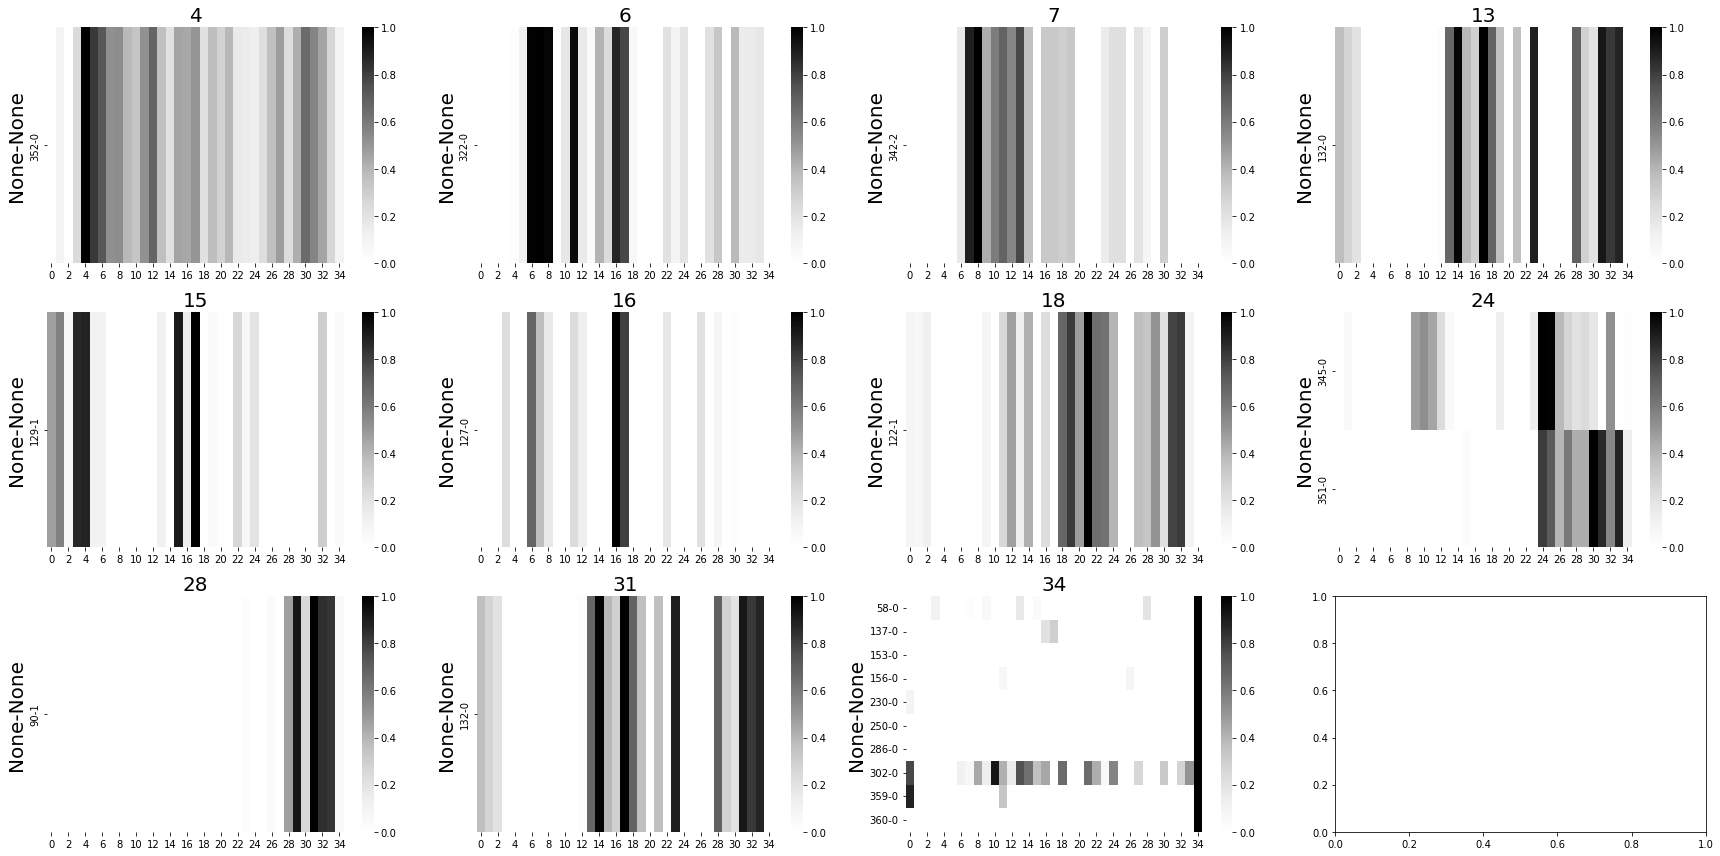

In [242]:
reload(cpp)
fig,axs=cpp.plot_fields_switching_each_trial(X_norm,inds_d.loc[1])

In [317]:
switch_on_both_d = {}
for task in [0,1]:
    switch_on_both_d[task]=((changes_df_d_all[(task,0)].loc[0.2]==1) | (changes_df_d_all[(task,1)].loc[0.2]==1)).dropna(how='all',axis=1)
common_fields = switch_on_both_d[0].index.intersection(switch_on_both_d[1].index)
for task in [0,1]:
    switch_on_both_d[task] = switch_on_both_d[task].loc[common_fields]

In [363]:
popup_trial_d={}
switch_on_d = {}
for key,X in X_all.items():
    popup_trial,switch_on = cpa.detect_popup(X,window=4,thresh=0.6,rate_thresh=0.5)
    popup_trial_d[key] = popup_trial
    switch_on_d[key] = switch_on

<AxesSubplot:>

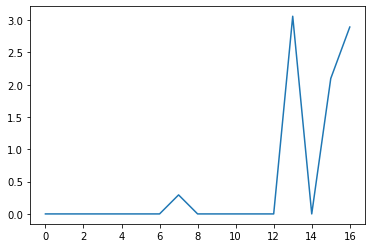

In [327]:
X_all[0,0].iloc[0].plot()

In [364]:
popup_trial_d = pd.concat(popup_trial_d,axis=1)

popup_trial_0 = popup_trial_d.loc[:,(0,slice(None),'trial')].dropna(how='all').min(axis=1)
popup_trial_1 = popup_trial_d.loc[:,(1,slice(None),'trial')].dropna(how='all').min(axis=1)

common = popup_trial_0.index.intersection(popup_trial_1.index)

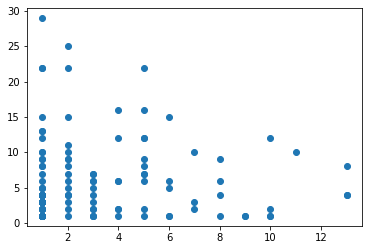

In [356]:
plt.scatter(popup_trial_0.loc[common],popup_trial_1.loc[common])


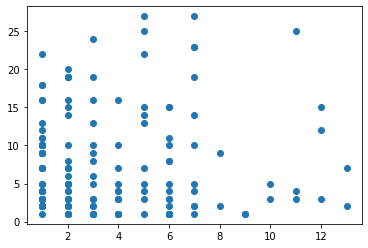

In [365]:
plt.scatter(popup_trial_0.loc[common],popup_trial_1.loc[common])


In [366]:
scipy.stats.spearmanr(popup_trial_0.loc[common],popup_trial_1.loc[common])

SpearmanrResult(correlation=-0.0723641223399461, pvalue=0.3469217481440603)

In [331]:
popup_trial_d[0,0,'trial'],popup_trial_d[0,0,'trial']

0                           1                      
        0.0           1.0           0.0           1.0        
      trial ispopup trial ispopup trial ispopup trial ispopup
1   0  13.0    True   NaN   False   NaN     NaN   NaN     NaN
39  0   NaN   False   NaN     NaN   NaN     NaN   1.0    True
40  0   NaN   False   NaN   False   NaN   False   3.0    True
    1   NaN   False   NaN     NaN   NaN   False   3.0    True
42  0   NaN   False   NaN     NaN   NaN   False   NaN   False
...     ...     ...   ...     ...   ...     ...   ...     ...
257 2   NaN     NaN   NaN     NaN   NaN     NaN   2.0    True
272 1   NaN     NaN   NaN     NaN   NaN     NaN   NaN   False
318 1   NaN     NaN   NaN     NaN   NaN     NaN   NaN   False
337 1   NaN     NaN   NaN     NaN   NaN     NaN   6.0    True
342 2   NaN     NaN   NaN     NaN   NaN     NaN   6.0    True

[484 rows x 8 columns]

In [318]:
switch_on_both_d[0].values

array([[False, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False,  True]])

In [ ]:
detect_popup(X,window=5,thresh=0.6,rate_thresh=0.1)

In [319]:
np.nonzero(switch_on_both_d[0].values)

(array([  1,   1,   4,   4,   4,   5,   6,   6,   7,   8,   8,  12,  13,
         13,  13,  14,  15,  15,  15,  17,  18,  19,  19,  19,  20,  20,
         21,  22,  25,  25,  25,  27,  27,  28,  29,  29,  30,  30,  30,
         31,  31,  32,  32,  33,  33,  33,  36,  36,  36,  37,  37,  37,
         38,  38,  39,  40,  41,  42,  43,  43,  44,  44,  44,  44,  44,
         45,  47,  47,  49,  49,  51,  51,  52,  52,  53,  53,  54,  55,
         55,  56,  57,  57,  58,  58,  59,  60,  61,  61,  62,  62,  63,
         64,  64,  65,  66,  66,  67,  67,  68,  69,  70,  71,  73,  75,
         76,  76,  77,  77,  78,  79,  80,  80,  80,  80,  81,  81,  81,
         82,  82,  83,  83,  83,  84,  85,  85,  85,  85,  86,  87,  87,
         87,  89,  89,  90,  90,  90,  92,  92,  92,  93,  93,  93,  94,
         96,  96,  97,  98,  98, 100, 100, 101, 101, 102, 103, 104, 105,
        106, 106, 107, 107, 108, 110, 110, 111, 112, 112, 112, 113, 113,
        114, 116, 116, 116, 117, 117, 117, 117, 118

In [306]:
switch_on_both_d[0]

1      2      3      4      5      6      7      8      9      10  \
39  0  False  False  False  False  False  False  False  False  False  False   
40  0  False   True  False  False   True  False  False  False  False  False   
    1  False  False  False  False  False  False  False  False  False  False   
42  0  False  False  False  False  False  False  False  False  False  False   
46  0  False  False   True  False   True  False  False   True  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
354 0  False  False  False  False  False  False  False   True  False  False   
356 0  False   True  False  False  False  False  False  False  False  False   
358 0  False  False  False  False  False  False  False  False  False   True   
359 0  False  False   True  False  False  False   True  False  False  False   
360 0  False  False   True  False  False  False  False  False  False   True   

       11  12  13  14  15  16  
39  0 NaN NaN NaN NaN NaN NaN  
40  0 NaN NaN NaN NaN NaN NaN  
    1 NaN NaN NaN NaN NaN NaN  
42  0 NaN NaN NaN NaN NaN NaN  
46  0 NaN NaN NaN NaN NaN NaN  
...    ..  ..  ..  ..  ..  ..  
354 0 NaN NaN NaN NaN NaN NaN  
356 0 NaN NaN NaN NaN NaN NaN  
358 0 NaN NaN NaN NaN NaN NaN  
359 0 NaN NaN NaN NaN NaN NaN  
360 0 NaN NaN NaN NaN NaN NaN  

[226 rows x 16 columns]

In [290]:
switch_on_both_d[0]

1      2      3      4      5      6      7      8      9      10  \
1   0  False  False  False  False  False  False  False  False  False  False   
39  0  False  False  False  False  False  False  False  False  False  False   
40  0  False   True  False  False   True  False  False  False  False  False   
    1  False  False  False  False  False  False  False  False  False  False   
42  0  False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
359 1  False  False  False  False  False  False  False  False  False  False   
360 0  False  False   True  False  False  False  False  False  False   True   
361 0  False  False  False   True   True  False  False  False  False  False   
    1  False  False  False  False  False  False  False  False  False  False   
362 0  False  False  False  False  False  False  False  False  False  False   

       11  12  13  14  15  16  
1   0 NaN NaN NaN NaN NaN NaN  
39  0 NaN NaN NaN NaN NaN NaN  
40  0 NaN NaN NaN NaN NaN NaN  
    1 NaN NaN NaN NaN NaN NaN  
42  0 NaN NaN NaN NaN NaN NaN  
...    ..  ..  ..  ..  ..  ..  
359 1 NaN NaN NaN NaN NaN NaN  
360 0 NaN NaN NaN NaN NaN NaN  
361 0 NaN NaN NaN NaN NaN NaN  
    1 NaN NaN NaN NaN NaN NaN  
362 0 NaN NaN NaN NaN NaN NaN  

[435 rows x 16 columns]

In [291]:
switch_on_both_d[1]

1      2      3      4      5      6      7      8      9      10  \
39  0  False  False  False  False  False  False  False  False  False  False   
40  0  False  False  False   True  False  False  False  False  False  False   
    1  False  False  False  False  False  False  False  False  False  False   
42  0  False  False  False  False  False  False  False  False  False  False   
    1  False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
354 0  False  False  False  False  False  False  False  False   True  False   
356 0  False  False  False  False  False  False  False  False  False  False   
358 0  False  False  False  False  False  False  False  False  False  False   
359 0  False  False  False  False  False  False  False  False  False  False   
360 0  False  False  False  False  False  False  False  False  False  False   

       ...     25     26     27     28     29     30     31     32  33  34  
39  0  ...  False  False  False  False  False  False  False  False NaN NaN  
40  0  ...  False  False  False  False  False  False  False  False NaN NaN  
    1  ...  False  False  False  False  False  False  False  False NaN NaN  
42  0  ...  False  False  False  False  False  False  False  False NaN NaN  
    1  ...  False  False  False  False  False  False  False  False NaN NaN  
...    ...    ...    ...    ...    ...    ...    ...    ...    ...  ..  ..  
354 0  ...  False  False  False  False  False  False   True  False NaN NaN  
356 0  ...  False  False  False  False  False   True   True  False NaN NaN  
358 0  ...  False  False  False  False  False  False  False  False NaN NaN  
359 0  ...  False  False  False  False  False  False  False  False NaN NaN  
360 0  ...  False  False  False  False  False  False  False  False NaN NaN  

[275 rows x 34 columns]

In [50]:
import change_point_analysis as cpa
reload(cpa)

<module 'change_point_analysis' from '/mnt/home/szheng/projects/nmf_analysis/change_point_analysis.py'>

CPU times: user 12.9 s, sys: 1.91 s, total: 14.8 s
Wall time: 10 s


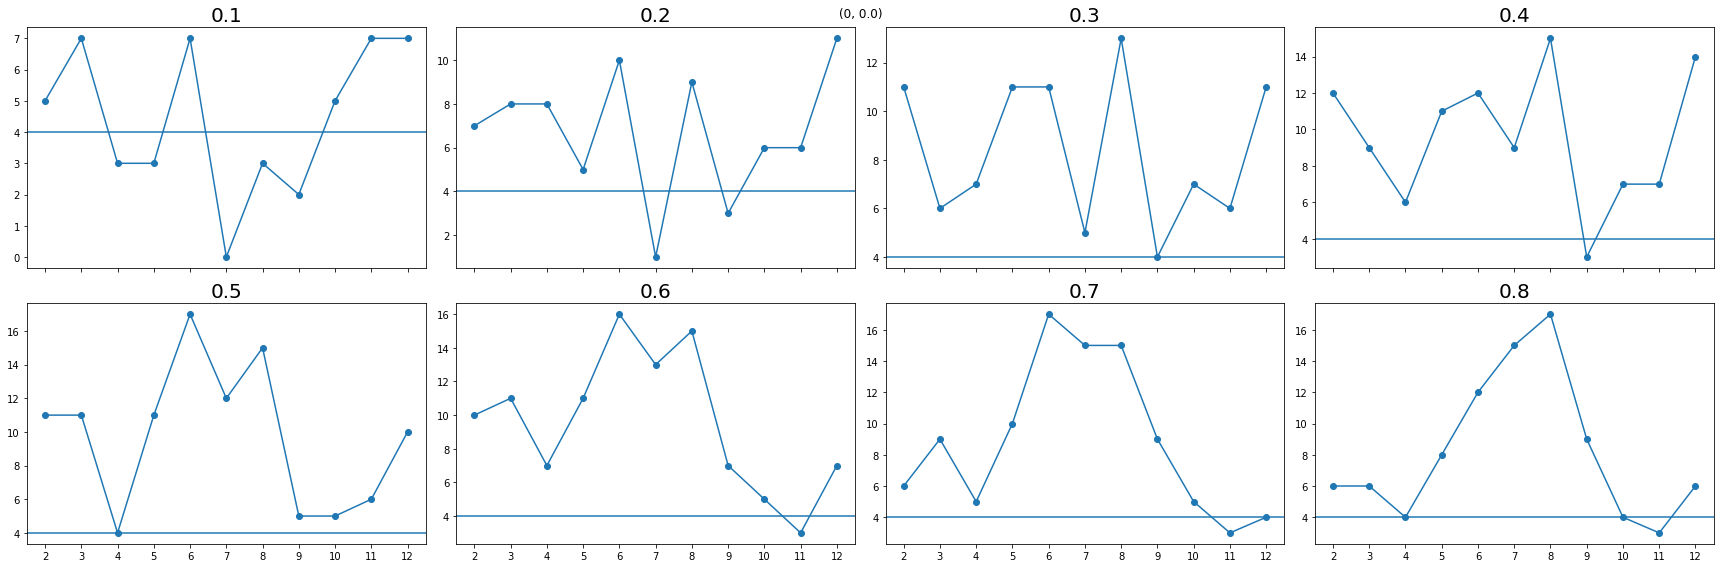

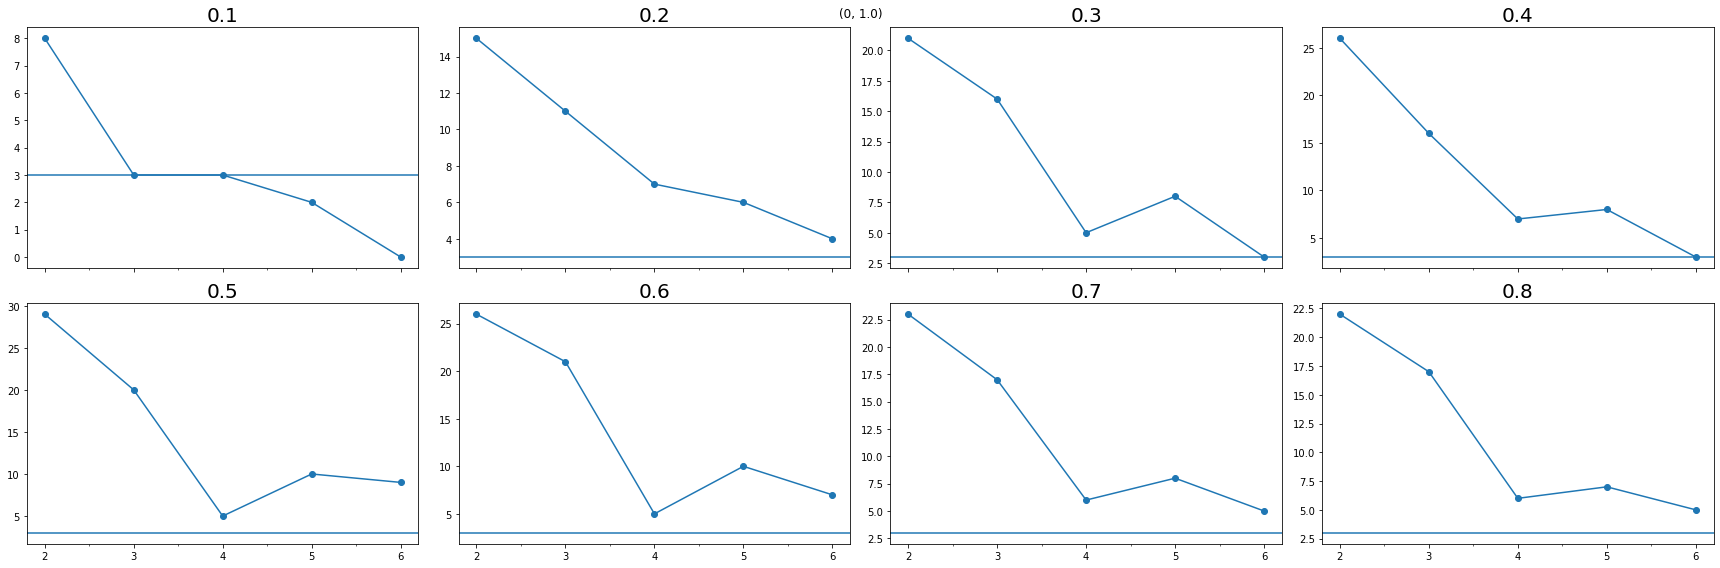

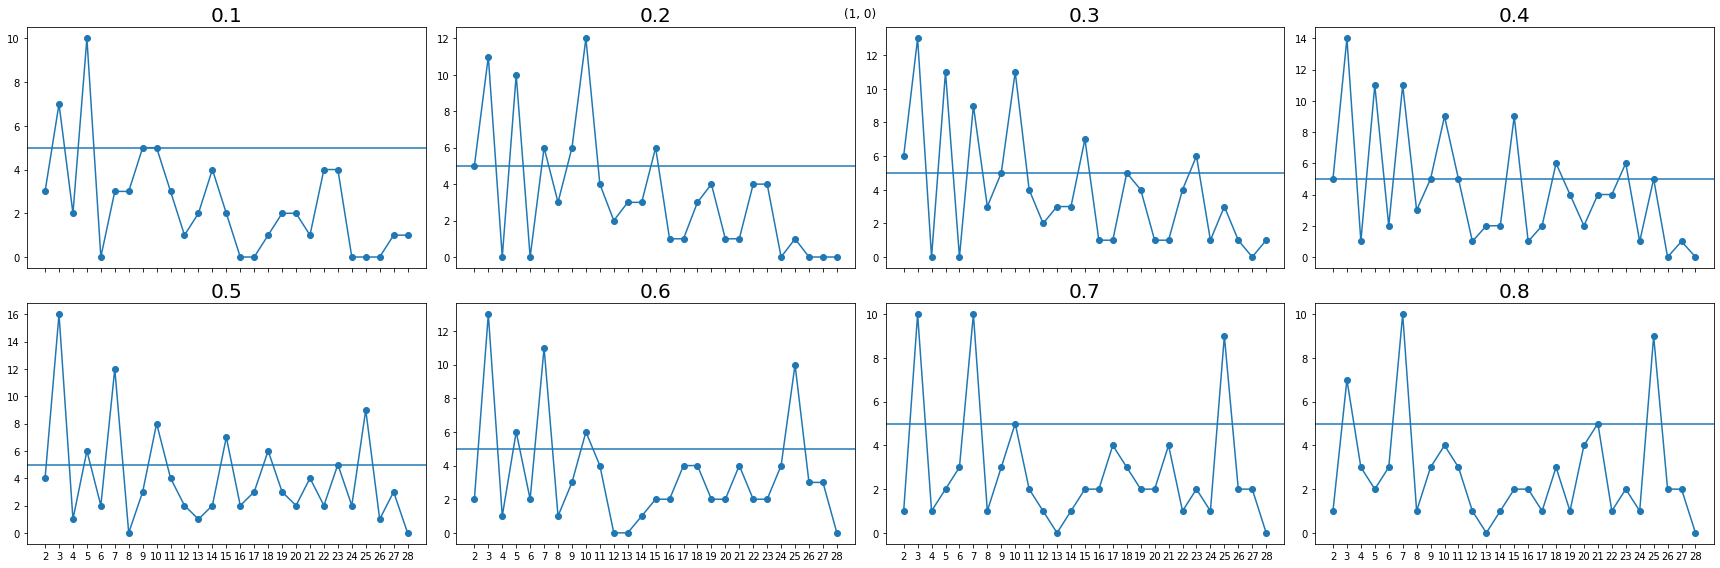

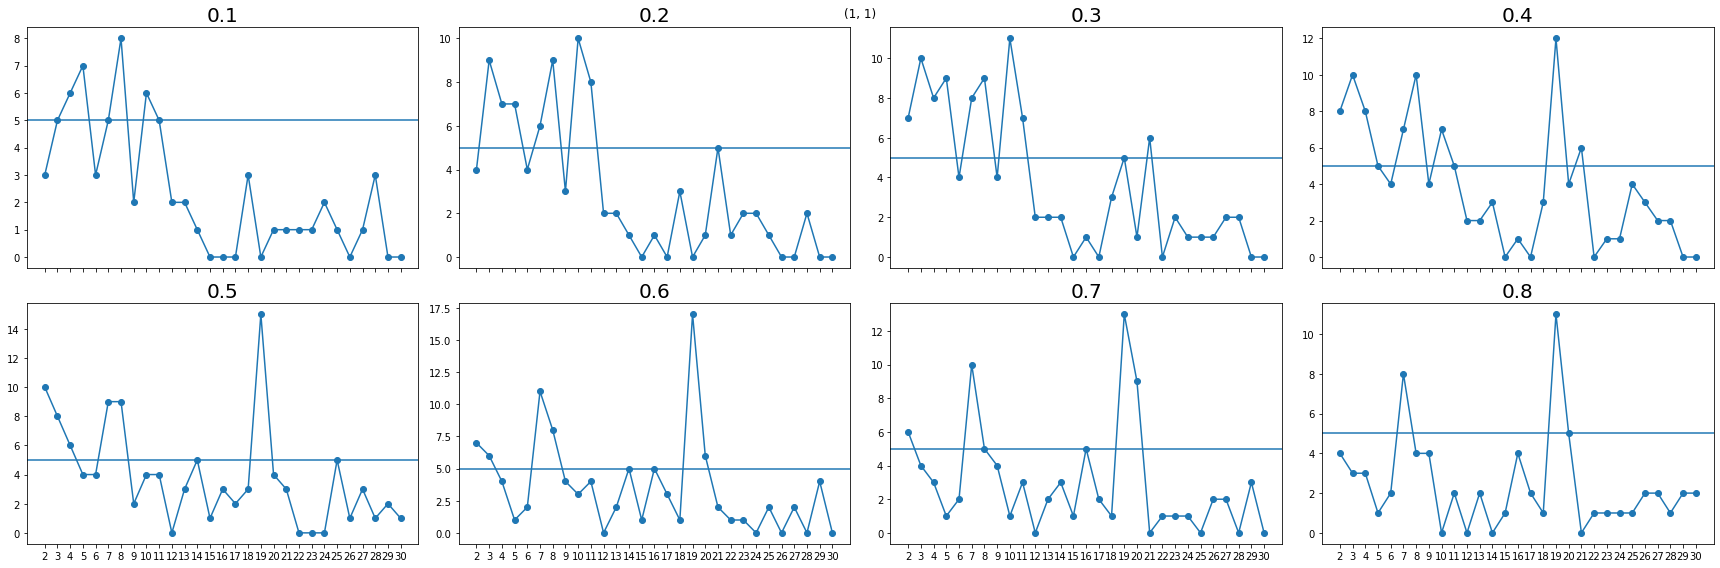

In [51]:
%%time
pen = 0.1
rate_thresh_l = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]

for key,X_norm_pwc in X_norm_pwc_d_allpen[pen].items():
    count_l,sig_ct_l,fig,axs = cpa.sweep_detect_popup(X_norm_pwc,rate_thresh_l,window=5,thresh=0.8,doplot=True,min_size=2,alpha=0.05)
    fig.suptitle(key)

In [120]:
pen = 0.2
popup_trial,switch_on=cpa.detect_popup(X_norm_pwc_d_allpen[pen][0,0] ,window=5,thresh=0.6,rate_thresh=0.3)

switch_on_possible=switch_on.iloc[:,2:-(4)]

switch_on_null = cpa.gen_circular_shuffle(switch_on_possible,nrepeats=200)

sr_l = cpa.get_switch_ratio_in_shuffles(switch_on_null,is_changes_df=True)

sr = cpa.get_switch_ratio_per_trial(switch_on_possible,skip_last_col=False)

reload(cpa)
cdf_d=cpa.test_sig_switch_ratio(sr,sr_l)

In [121]:
cdf_d

on  off
2.0   0.385  0.0
3.0   0.165  0.0
4.0   0.045  0.0
5.0   0.345  0.0
6.0   0.990  0.0
7.0   0.065  0.0
8.0   0.475  0.0
9.0   0.060  0.0
10.0  0.530  0.0
11.0  0.460  0.0
12.0  0.960  0.0

In [122]:
sr

{'on': 2.0     0.020833
 3.0     0.017857
 4.0     0.008929
 5.0     0.017857
 6.0     0.041667
 7.0     0.011905
 8.0     0.023810
 9.0     0.011905
 10.0    0.023810
 11.0    0.020833
 12.0    0.035714
 dtype: float64,
 'off': 2.0     0.0
 3.0     0.0
 4.0     0.0
 5.0     0.0
 6.0     0.0
 7.0     0.0
 8.0     0.0
 9.0     0.0
 10.0    0.0
 11.0    0.0
 12.0    0.0
 dtype: float64}

In [88]:
sr_l

[{'on': 0.0     0.029762
  1.0     0.011905
  2.0     0.005952
  3.0     0.011905
  4.0     0.023810
  5.0     0.002976
  6.0     0.008929
  7.0     0.011905
  8.0     0.023810
  9.0     0.020833
  10.0    0.017857
  11.0    0.014881
  12.0    0.008929
  13.0    0.014881
  14.0    0.026786
  15.0    0.011905
  16.0    0.026786
  dtype: float64,
  'off': 0.0     0.0
  1.0     0.0
  2.0     0.0
  3.0     0.0
  4.0     0.0
  5.0     0.0
  6.0     0.0
  7.0     0.0
  8.0     0.0
  9.0     0.0
  10.0    0.0
  11.0    0.0
  12.0    0.0
  13.0    0.0
  14.0    0.0
  15.0    0.0
  16.0    0.0
  dtype: float64},
 {'on': 0.0     0.017857
  1.0     0.008929
  2.0     0.020833
  3.0     0.011905
  4.0     0.014881
  5.0     0.011905
  6.0     0.017857
  7.0     0.026786
  8.0     0.023810
  9.0     0.008929
  10.0    0.029762
  11.0    0.014881
  12.0    0.008929
  13.0    0.008929
  14.0    0.017857
  15.0    0.014881
  16.0    0.014881
  dtype: float64,
  'off': 0.0     0.0
  1.0     0.0
  2.0  

In [81]:
scipy.stats.binom.ppf(0.99,11,0.09)

4.0

In [73]:
1 / 11

0.09090909090909091

In [72]:
switch_on.iloc[:,2:-(4)].sum().sum()

92

In [63]:
switch_on.iloc[:,2:-(4)].shape

(336, 11)

In [65]:
switch_on.iloc[:,2:-(4)].sum().mean() 

8.363636363636363

In [59]:
switch_on.iloc[:,2:-(4)].sum().mean()

2.0     11
3.0      6
4.0      7
5.0     11
6.0     11
7.0      5
8.0     13
9.0      4
10.0     7
11.0     6
12.0    11
dtype: int64

In [55]:
popup_trial

trial  ispopup
1   0    NaN    False
39  0    NaN    False
40  0    NaN    False
    1    NaN    False
42  0    NaN    False
...      ...      ...
358 0   10.0     True
    1    7.0     True
359 0    NaN    False
360 0    9.0     True
361 0    NaN    False

[336 rows x 2 columns]